In [1]:
import itertools
import numpy as np
import pandas as pd
import MDAnalysis as mda
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import pyemma
from pyemma.coordinates import source
from pyemma.util.contexts import settings
from pyemma.coordinates.data.featurization.misc import GroupCOMFeature


In [2]:
pwd

'/scratch/general/nfs1/u1266568/msm_v2.2/tica'

In [3]:
arr1 = [pyemma.coordinates.load(f'../adaptive_sampling_features/feats_prod/min_dist_{i:03d}.npy') for i in range(11)]


In [4]:
arr2 = [pyemma.coordinates.load(f'../adaptive_sampling_features/feats_prod/contacts_{i:03d}.npy') for i in range(11)]


In [5]:
arr3 = [pyemma.coordinates.load(f'../adaptive_sampling_features/feats_prod/sidechain_dists_{i:03d}.npy') for i in range(11)]


In [6]:
arr4 = [pyemma.coordinates.load(f'../adaptive_sampling_features/feats_prod/ca_pairs_{i:03d}.npy') for i in range(11)]


In [7]:
def slice_features_at_index(arr, index=9):
    """
    Slice the features of a given trajectory in half.
    
    Parameters:
    - arr: The feature array
    - index: The index of the trajectory's features in the array
    """
    traj_features = arr[index]
    mid_point = traj_features.shape[0] // 2
    sliced_features = traj_features[:mid_point]
    arr[index] = sliced_features
    return arr

# Apply the function to each of the arrays
arr1 = slice_features_at_index(arr1)
arr2 = slice_features_at_index(arr2)
arr3 = slice_features_at_index(arr3)
arr4 = slice_features_at_index(arr4)


In [30]:
np.shape(arr4[9])

(7635, 224)

In [42]:
combo_combined = [np.concatenate([a1, a2, a3, a4], axis=1) for a1, a2, a3, a4  in zip(arr1, arr2, arr3, arr4 )]


In [137]:
combo_combined = [np.concatenate([a1, a2], axis=1) for a1, a2 in zip(arr2,  arr3 )]


# Make traj6 shorter

In [135]:
import MDAnalysis as mda

# Load the trajectory
u = mda.Universe('../adaptive_sampling_features/10.gro', '../../trajdat/rep6_tot2.xtc')

# Determine the midpoint
mid_point = len(u.trajectory) // 2

# Slice the trajectory
sliced_traj = u.trajectory[:mid_point]



In [136]:
sliced_traj

In [32]:
np.shape(combo_combined[0])

(17501, 335)

In [68]:
tica_dev = pyemma.coordinates.tica(combo_combined, lag=10, var_cutoff=.7)
tica_out = tica_dev.get_output()
tica_concatenated = np.concatenate(tica_out)

calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

In [35]:
tica_dev.dimension


<bound method TICABase.dimension of TICA(commute_map=False, dim=6, epsilon=1e-06, kinetic_map=True, lag=50,
   ncov_max=inf, reversible=True, skip=0, stride=1, var_cutoff=0.95,
   weights=None)>

In [36]:
# Number of ICs and top features to consider
n_ics = 1
n_top_features = 20

# Extract the ICs from tICA on combined features
ics_combined = tica_dev.eigenvectors[:n_ics]

# A dictionary to store weights and their indices
weights_dict_combined = {}

# Iterate over each IC
for i, ic in enumerate(ics_combined):
    # Get the indices of the top weights by magnitude
    top_indices = np.argsort(np.abs(ic))[-n_top_features:]
    
    # Update the dictionary with the new weights and indices
    for idx in top_indices:
        weights_dict_combined[idx] = ic[idx]

# Sort the dictionary by the magnitude of weights in descending order
sorted_weights_combined = sorted(weights_dict_combined.items(), key=lambda x: np.abs(x[1]), reverse=True)

# Map the indices back to the original arrays
length_arr1 = arr1[0].shape[1]  # Number of features in arr1
length_arr2 = arr2[0].shape[1]  # Number of features in arr2
length_arr3 = arr3[0].shape[1]  # Number of features in arr3
length_arr4 = arr4[0].shape[1]  # Number of features in arr4

for idx, weight in sorted_weights_combined:
    if idx < length_arr1:
        print(f"Feature comes from arr1, Index: {idx + 1}, Weight: {weight:.4f}")
    elif idx < (length_arr1 + length_arr2):
        print(f"Feature comes from arr2, Index: {idx - length_arr1 + 1}, Weight: {weight:.4f}")
    elif idx < (length_arr1 + length_arr2 + length_arr3):
        print(f"Feature comes from arr3, Index: {idx - length_arr1 - length_arr2 + 1}, Weight: {weight:.4f}")
    else:
        print(f"Feature comes from arr4, Index: {idx - length_arr1 - length_arr2 - length_arr3 + 1}, Weight: {weight:.4f}")


Feature comes from arr4, Index: 1, Weight: 0.1982
Feature comes from arr1, Index: 37, Weight: -0.1957
Feature comes from arr1, Index: 9, Weight: 0.1700
Feature comes from arr1, Index: 24, Weight: 0.1689
Feature comes from arr2, Index: 1, Weight: -0.1657
Feature comes from arr2, Index: 11, Weight: -0.1505
Feature comes from arr1, Index: 19, Weight: -0.1422
Feature comes from arr3, Index: 14, Weight: -0.1395
Feature comes from arr3, Index: 5, Weight: 0.1369
Feature comes from arr1, Index: 7, Weight: -0.1359
Feature comes from arr3, Index: 26, Weight: -0.1352
Feature comes from arr3, Index: 1, Weight: -0.1335
Feature comes from arr1, Index: 36, Weight: -0.1276
Feature comes from arr1, Index: 33, Weight: 0.1139
Feature comes from arr3, Index: 37, Weight: 0.1127
Feature comes from arr3, Index: 35, Weight: 0.1127
Feature comes from arr2, Index: 9, Weight: 0.1101
Feature comes from arr2, Index: 27, Weight: 0.1079
Feature comes from arr4, Index: 43, Weight: -0.1057
Feature comes from arr3, Ind

In [38]:
np.shape(tica_concatenated[0])

(6,)

In [76]:
np.shape(tica_concatenated)

(130963, 4)

# tICA stuff

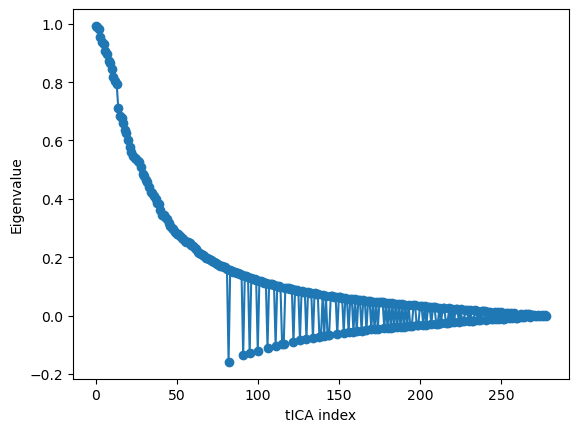

In [39]:
import matplotlib.pyplot as plt

eigenvalues = tica_dev.eigenvalues
plt.plot(eigenvalues, 'o-')
plt.xlabel('tICA index')
plt.ylabel('Eigenvalue')
# plt.savefig('eigenvalues_min_dist.png',dpi=400)
plt.show()


In [47]:
def extract_significant_features(tica_model, top_n=5):
    significant_features = []
    for i, eigenvector in enumerate(tica_model.eigenvectors[:top_n]):
        # Get the indices of the features with the top contributions
        top_features_indices = np.argsort(np.abs(eigenvector))[-top_n:]
        significant_features.append(top_features_indices)
    return significant_features

top_n = 5  # you can adjust this number as per your needs
significant_features = extract_significant_features(tica_dev, top_n=top_n)
print(significant_features)


[array([ 7, 18, 10, 16, 31]), array([54, 65, 31, 41,  7]), array([59, 63, 41, 28, 32]), array([61, 21, 35, 25, 56]), array([24, 50, 22, 18, 49])]


In [99]:
pwd

'/mnt/c/users/jay/desktop/modules/modules/msm_chpc'

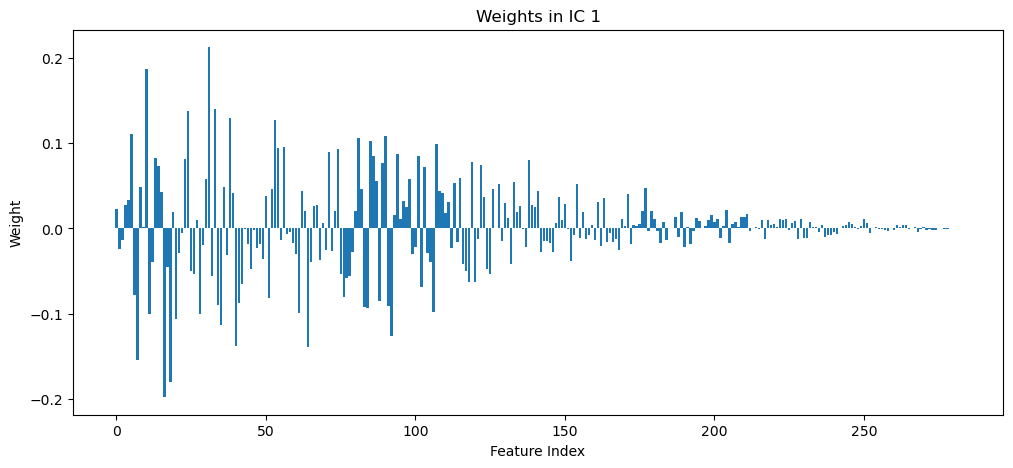

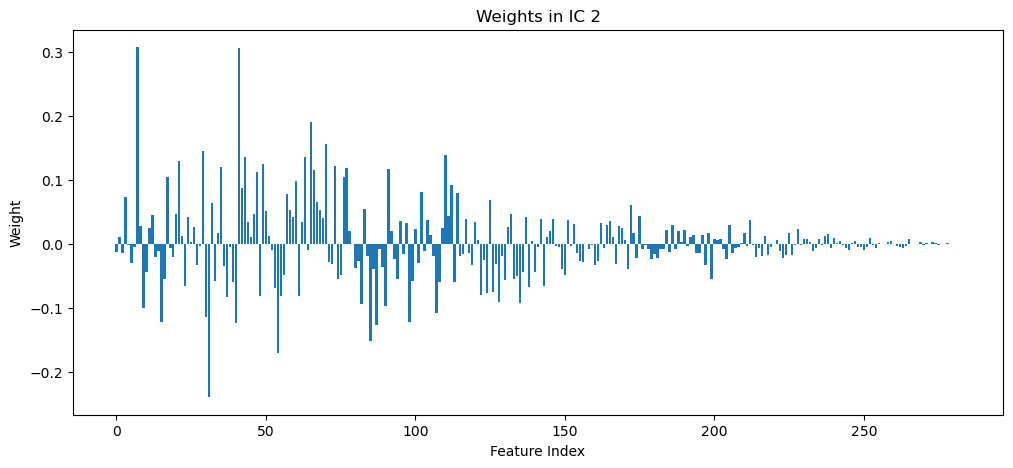

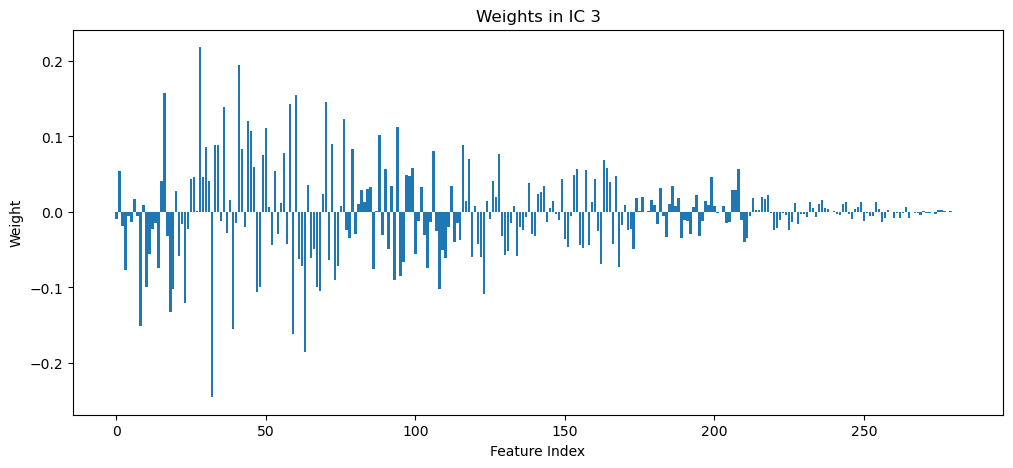

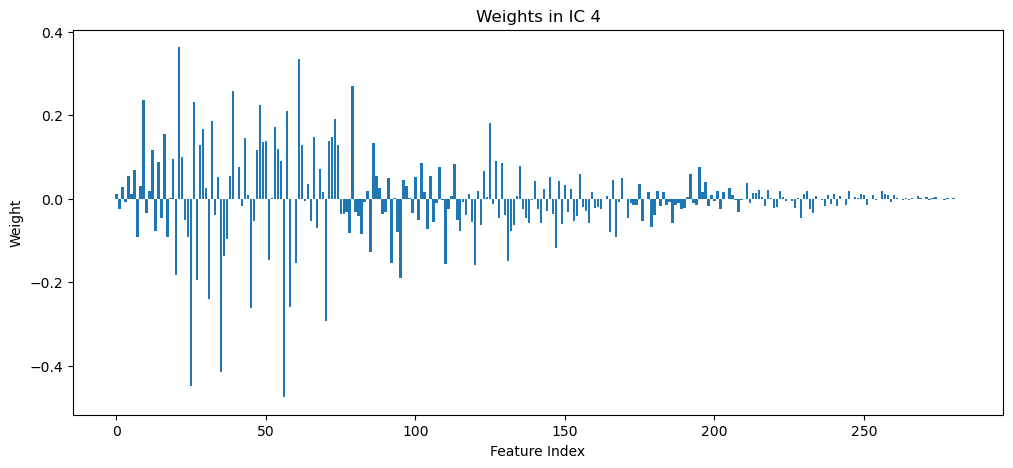

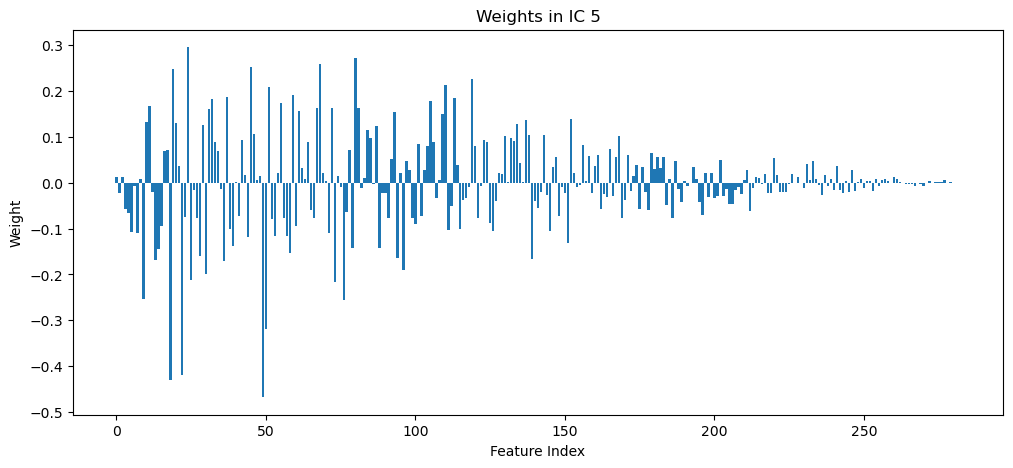

In [48]:
import matplotlib.pyplot as plt

# Number of ICs to visualize
num_ics = 5

# Extract the first 5 ICs (eigenvectors)
ics = tica_dev.eigenvectors[:num_ics]

# Plot each IC's feature weights
for i, ic in enumerate(ics):
    plt.figure(figsize=(12, 5))
    plt.bar(range(len(ic)), ic)
    plt.title(f'Weights in IC {i+1}')
    plt.xlabel('Feature Index')
    plt.ylabel('Weight')
    plt.show()


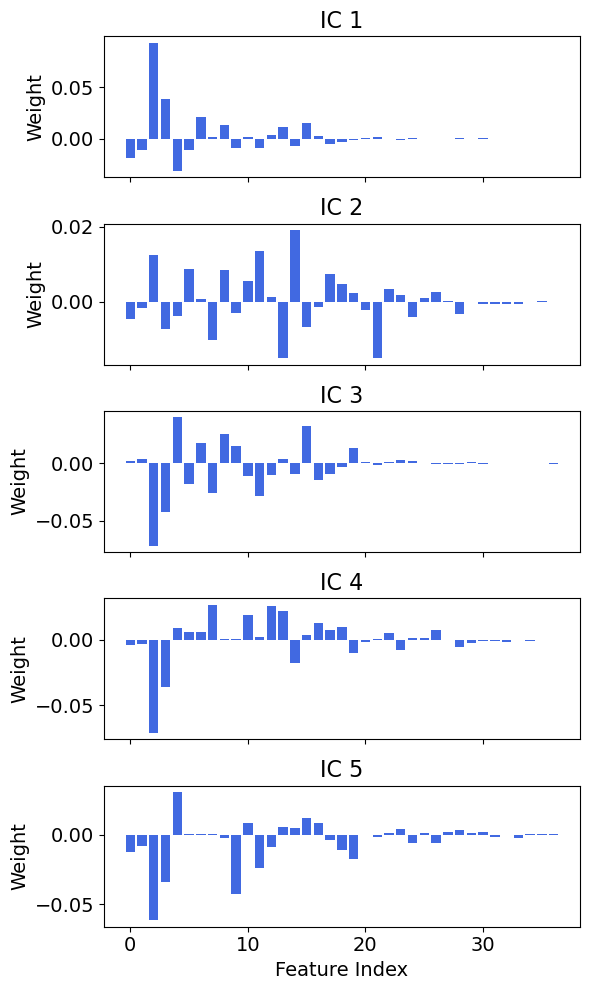

In [101]:
import matplotlib.pyplot as plt

# Number of ICs to visualize
num_ics = 5

# Extract the first 5 ICs (eigenvectors)
ics = tica_dev.eigenvectors[:num_ics]

# Set up the figure and axes for a concise presentation
fig, axes = plt.subplots(nrows=num_ics, ncols=1, figsize=(6, 2 * num_ics), sharex=True)

# Customize and plot each IC's feature weights
for i, (ic, ax) in enumerate(zip(ics, axes)):
    ax.bar(range(len(ic)), ic, color='royalblue')
    ax.set_title(f'IC {i+1}', fontsize=16)
    ax.tick_params(labelsize=14)
    ax.set_ylabel('Weight', fontsize=14)

# Common settings
axes[-1].set_xlabel('Feature Index', fontsize=14)
plt.tight_layout()
plt.savefig('weights_contacts.png',dpi=400)
plt.show()


In [102]:
# Extract IC1
ic1 = tica_dev.eigenvectors[0]

# Get the indices of the top 10 weights by magnitude
top_10_indices = np.argsort(np.abs(ic1))[-5:]

# Extract the top 10 weights using these indices
top_10_weights = ic1[top_10_indices]

print(f"Indices of top 10 features by magnitude: {top_10_indices}")
print(f"Top 10 weights by magnitude: {top_10_weights}")


Indices of top 10 features by magnitude: [0 6 4 3 2]
Top 10 weights by magnitude: [-0.01865163  0.02093037 -0.03108752  0.03817551  0.09306708]


In [265]:
# Number of ICs and top features to consider
n_ics = 4
n_top_features = 5

# Extract the ICs
ics = tica_dev2.eigenvectors[:n_ics]

# Use a dictionary to store weights and their indices
weights_dict = {}

# Iterate over each IC
for i, ic in enumerate(ics):
    # Get the indices of the top weights by magnitude
    top_indices = np.argsort(np.abs(ic))[-n_top_features:]
    
    # Update the dictionary with the new weights and indices
    for idx in top_indices:
        weights_dict[idx] = ic[idx]

# Sort the dictionary by the magnitude of weights in descending order
sorted_weights = sorted(weights_dict.items(), key=lambda x: np.abs(x[1]), reverse=True)

# Print the sorted weights with their magnitudes and indices
for idx, weight in sorted_weights:
    print(f"Index (adjusted): {idx + 1}, Weight: {weight:.4f}, Magnitude: {np.abs(weight):.4f}")


Index (adjusted): 15, Weight: 1.3829, Magnitude: 1.3829
Index (adjusted): 18, Weight: 1.0412, Magnitude: 1.0412
Index (adjusted): 28, Weight: -0.9844, Magnitude: 0.9844
Index (adjusted): 43, Weight: 0.9742, Magnitude: 0.9742
Index (adjusted): 23, Weight: -0.9633, Magnitude: 0.9633
Index (adjusted): 12, Weight: -0.8007, Magnitude: 0.8007
Index (adjusted): 31, Weight: 0.7549, Magnitude: 0.7549
Index (adjusted): 29, Weight: 0.7492, Magnitude: 0.7492
Index (adjusted): 13, Weight: -0.7260, Magnitude: 0.7260
Index (adjusted): 10, Weight: -0.7131, Magnitude: 0.7131
Index (adjusted): 26, Weight: -0.7061, Magnitude: 0.7061
Index (adjusted): 34, Weight: -0.6852, Magnitude: 0.6852
Index (adjusted): 41, Weight: 0.6439, Magnitude: 0.6439
Index (adjusted): 17, Weight: 0.6364, Magnitude: 0.6364
Index (adjusted): 27, Weight: 0.6110, Magnitude: 0.6110
Index (adjusted): 35, Weight: 0.5828, Magnitude: 0.5828
Index (adjusted): 22, Weight: 0.5654, Magnitude: 0.5654
Index (adjusted): 21, Weight: 0.5409, Mag

In [13]:
# Extract the indices of top features from sorted_weights
top_feature_indices = [idx for idx, _ in sorted_weights]

# Extract top features from each trajectory
top_features = [traj[:, top_feature_indices] for traj in arr1]




NameError: name 'sorted_weights' is not defined

In [8]:
def get_sorted_weights_and_indices(data, n_ics=5, n_top_features=5):
    tica_obj = pyemma.coordinates.tica(data, lag=20)
    ics = tica_obj.eigenvectors[:n_ics]
    
    # Use a dictionary to store weights and their indices
    weights_dict = {}

    # Iterate over each IC
    for i, ic in enumerate(ics):
        # Get the indices of the top weights by magnitude
        top_indices = np.argsort(np.abs(ic))[-n_top_features:]
        
        # Update the dictionary with the new weights and indices
        for idx in top_indices:
            weights_dict[idx] = ic[idx]

    # Sort the dictionary by the magnitude of weights in descending order
    sorted_weights = sorted(weights_dict.items(), key=lambda x: np.abs(x[1]), reverse=True)
    
    # Extract the indices of top features from sorted_weights
    top_feature_indices = [idx for idx, _ in sorted_weights]
    
    return sorted_weights, top_feature_indices

# Compute the sorted weights and top indices for each feature set
sorted_weights_arr1, top_indices_arr1 = get_sorted_weights_and_indices(arr1)
sorted_weights_arr2, top_indices_arr2 = get_sorted_weights_and_indices(arr2)
sorted_weights_arr3, top_indices_arr3 = get_sorted_weights_and_indices(arr3)
sorted_weights_arr4, top_indices_arr4 = get_sorted_weights_and_indices(arr4)

# Extend this for more feature sets as needed...


calculate covariances:   0%|                                                                                  …

calculate covariances:   0%|                                                                                  …

calculate covariances:   0%|                                                                                  …

calculate covariances:   0%|                                                                                  …

In [9]:

# Extract the top features from each feature set
top_features_arr1 = [traj[:, top_indices_arr1] for traj in arr1]
top_features_arr2 = [traj[:, top_indices_arr2] for traj in arr2]
top_features_arr3 = [traj[:, top_indices_arr3] for traj in arr3]
top_features_arr4 = [traj[:, top_indices_arr4] for traj in arr4]



In [10]:
# Concatenate the top features from all feature sets for each trajectory
combined_features = [np.hstack((feat1, feat2, feat3,feat4)) for feat1, feat2, feat3, feat4 in zip(top_features_arr1, top_features_arr2, top_features_arr3, top_features_arr4)]


In [11]:
np.shape(combined_features[0])

(17501, 59)

In [12]:
def get_sorted_weights_and_indices2(data, n_ics=4, n_top_features=5):
    tica_obj = pyemma.coordinates.tica(data, lag=20)
    ics = tica_obj.eigenvectors[:n_ics]
    
    # Use a dictionary to store weights and their indices
    weights_dict = {}

    # Iterate over each IC
    for i, ic in enumerate(ics):
        # Get the indices of the top weights by magnitude
        top_indices = np.argsort(np.abs(ic))[-n_top_features:]
        
        # Update the dictionary with the new weights and indices
        for idx in top_indices:
            weights_dict[idx] = ic[idx]

    # Sort the dictionary by the magnitude of weights in descending order
    sorted_weights = sorted(weights_dict.items(), key=lambda x: np.abs(x[1]), reverse=True)
    
    # Extract the indices of top features from sorted_weights
    top_feature_indices = [idx for idx, _ in sorted_weights]
    
    return sorted_weights, top_feature_indices

In [13]:
sorted_weights_top_arr1, top_indices_top_arr1 = get_sorted_weights_and_indices2(top_features_arr1)
sorted_weights_top_arr2, top_indices_top_arr2 = get_sorted_weights_and_indices2(top_features_arr2)
sorted_weights_top_arr3, top_indices_top_arr3 = get_sorted_weights_and_indices2(top_features_arr3)
sorted_weights_top_arr4, top_indices_top_arr4 = get_sorted_weights_and_indices2(top_features_arr4)


calculate covariances:   0%|                                                                                  …

calculate covariances:   0%|                                                                                  …

calculate covariances:   0%|                                                                                  …

calculate covariances:   0%|                                                                                  …

In [14]:
top_of_top_features_arr1 = [traj[:, top_indices_top_arr1] for traj in top_features_arr1]
top_of_top_features_arr2 = [traj[:, top_indices_top_arr2] for traj in top_features_arr2]
top_of_top_features_arr3 = [traj[:, top_indices_top_arr3] for traj in top_features_arr3]
top_of_top_features_arr4 = [traj[:, top_indices_top_arr4] for traj in top_features_arr4]


In [15]:
combined_top_top = [np.hstack((feat1, feat2, feat3, feat4)) for feat1, feat2, feat3, feat4 in zip(top_of_top_features_arr1, top_of_top_features_arr2, top_of_top_features_arr3, top_of_top_features_arr4)]


In [16]:
np.shape(top_features_arr1[0])

(17501, 17)

In [17]:
print("Top indices for arr1:", top_indices_top_arr1)
print("Top indices for arr2:", top_indices_top_arr2)
print("Top indices for arr3:", top_indices_top_arr3)
print("Top indices for arr4:", top_indices_top_arr4)


Top indices for arr1: [1, 9, 5, 4, 3, 6, 13, 10, 2, 11, 7, 16]
Top indices for arr2: [8, 7, 3, 11, 9, 12, 6, 5, 16, 4, 2, 10]
Top indices for arr3: [2, 3, 6, 5, 1, 4, 0, 8]
Top indices for arr4: [10, 4, 5, 6, 3, 8, 2, 12, 11]


In [15]:
np.shape(combined_top_of_top_features[0])

NameError: name 'combined_top_of_top_features' is not defined

In [106]:
# Perform tICA on combined features
tica_combined = pyemma.coordinates.tica(combined_features, lag=50)
ics_combined = tica_combined.eigenvectors[:1]  # Adjust the number of ICs if needed

# Dictionary to store weights and their indices for combined features
weights_dict_combined = {}

# Extract top weights from tICA components
for i, ic in enumerate(ics_combined):
    top_indices = np.argsort(np.abs(ic))[-5:]  # Taking the top 5 as an example; adjust if needed
    
    for idx in top_indices:
        weights_dict_combined[idx] = ic[idx]

# Sort weights by magnitude
sorted_weights_combined = sorted(weights_dict_combined.items(), key=lambda x: np.abs(x[1]), reverse=True)

# Map sorted weights back to the original arrays
length_arr1 = top_features_arr1[0].shape[1]
length_arr2 = top_features_arr2[0].shape[1]
length_arr3 = top_features_arr3[0].shape[1]
length_arr4 = top_features_arr4[0].shape[1]

for idx, weight in sorted_weights_combined:
    if idx < length_arr1:
        original_index = top_indices_arr1[idx % length_arr1]
        print(f"Feature comes from arr1, Original Index: {original_index + 1}, Weight: {weight:.4f}")
    elif idx < (length_arr1 + length_arr2):
        original_index = top_indices_arr2[idx % length_arr2]
        print(f"Feature comes from arr2, Original Index: {original_index + 1}, Weight: {weight:.4f}")
    elif idx < (length_arr1 + length_arr2 + length_arr3):
        original_index = top_indices_arr3[idx % length_arr3]
        print(f"Feature comes from arr3, Original Index: {original_index + 1}, Weight: {weight:.4f}")
    else:
        original_index = top_indices_arr4[idx % length_arr4]
        print(f"Feature comes from arr4, Original Index: {original_index + 1}, Weight: {weight:.4f}")


calculate covariances:   0%|                             | 0/11 [00:00<?, ?it/s]

Feature comes from arr2, Original Index: 30, Weight: 0.7491
Feature comes from arr2, Original Index: 28, Weight: 0.6699
Feature comes from arr2, Original Index: 18, Weight: -0.6465
Feature comes from arr2, Original Index: 34, Weight: 0.4671
Feature comes from arr2, Original Index: 19, Weight: 0.4599


In [18]:
# Specify the desired IC
desired_ic = 0 # for IC2; note that the index starts from 0

# Perform tICA on combined features
tica_combined = pyemma.coordinates.tica(combined_features, lag=50)
selected_ic = tica_combined.eigenvectors[desired_ic]

# Dictionary to store weights and their indices for the selected IC
weights_dict_selected = {}

# Extract top weights from the selected IC
top_indices = np.argsort(np.abs(selected_ic))[-10:]  # Taking the top 5 as an example; adjust if needed
for idx in top_indices:
    weights_dict_selected[idx] = selected_ic[idx]

# Sort weights by magnitude
sorted_weights_selected = sorted(weights_dict_selected.items(), key=lambda x: np.abs(x[1]), reverse=True)

# Map sorted weights back to the original arrays
length_arr1 = top_features_arr1[0].shape[1]
length_arr2 = top_features_arr2[0].shape[1]
length_arr3 = top_features_arr3[0].shape[1]
length_arr4 = top_features_arr4[0].shape[1]

for idx, weight in sorted_weights_selected: 
    if idx < length_arr1:
        original_index = top_indices_arr1[idx % length_arr1]
        print(f"Feature comes from arr1, Original Index: {original_index + 1}, Weight: {weight:.4f}")
    elif idx < (length_arr1 + length_arr2):
        original_index = top_indices_arr2[idx % length_arr2]
        print(f"Feature comes from arr2, Original Index: {original_index + 1}, Weight: {weight:.4f}")
    elif idx < (length_arr1 + length_arr2 + length_arr3):
        original_index = top_indices_arr3[idx % length_arr3]
        print(f"Feature comes from arr3, Original Index: {original_index + 1}, Weight: {weight:.4f}")
    else:
        original_index = top_indices_arr4[idx % length_arr4]
        print(f"Feature comes from arr4, Original Index: {original_index + 1}, Weight: {weight:.4f}")


calculate covariances:   0%|                                                                                  …

Feature comes from arr1, Original Index: 13, Weight: 0.5311
Feature comes from arr2, Original Index: 10, Weight: 0.4902
Feature comes from arr1, Original Index: 25, Weight: -0.4884
Feature comes from arr2, Original Index: 14, Weight: -0.4384
Feature comes from arr1, Original Index: 16, Weight: 0.4291
Feature comes from arr2, Original Index: 1, Weight: -0.3851
Feature comes from arr1, Original Index: 17, Weight: 0.3465
Feature comes from arr3, Original Index: 6, Weight: 0.3135
Feature comes from arr3, Original Index: 11, Weight: -0.2902
Feature comes from arr3, Original Index: 14, Weight: 0.2702


In [20]:
# Specify the desired IC
desired_ic = 3  # for IC1; note that the index starts from 0

# Perform tICA on combined_top_of_top_features
tica_combined = pyemma.coordinates.tica(combined_top_top, lag=50)
selected_ic = tica_combined.eigenvectors[desired_ic]

# Dictionary to store weights and their indices for the selected IC
weights_dict_selected = {}

# Extract top weights from the selected IC
top_indices = np.argsort(np.abs(selected_ic))[-10:]  # Taking the top 10 as an example; adjust if needed
for idx in top_indices:
    weights_dict_selected[idx] = selected_ic[idx]

# Sort weights by magnitude
sorted_weights_selected = sorted(weights_dict_selected.items(), key=lambda x: np.abs(x[1]), reverse=True)

# Map sorted weights back to the original arrays
length_arr1 = len(top_indices_top_arr1)
length_arr2 = len(top_indices_top_arr2)
length_arr3 = len(top_indices_top_arr3)
length_arr4 = len(top_indices_top_arr4)

cumulative_lengths = [length_arr1, length_arr1 + length_arr2, length_arr1 + length_arr2 + length_arr3]

for idx, weight in sorted_weights_selected:
    if idx < cumulative_lengths[0]:
        original_index = top_indices_top_arr1[idx]
        print(f"Feature comes from arr1, Original Index: {original_index + 1}, Weight: {weight:.4f}")
    elif idx < cumulative_lengths[1]:
        original_index = top_indices_top_arr2[idx - cumulative_lengths[0]]
        print(f"Feature comes from arr2, Original Index: {original_index + 1}, Weight: {weight:.4f}")
    elif idx < cumulative_lengths[2]:
        original_index = top_indices_top_arr3[idx - cumulative_lengths[1]]
        print(f"Feature comes from arr3, Original Index: {original_index + 1}, Weight: {weight:.4f}")
    else:
        original_index = top_indices_top_arr4[idx - cumulative_lengths[2]]
        print(f"Feature comes from arr4, Original Index: {original_index + 1}, Weight: {weight:.4f}")


calculate covariances:   0%|                                                                                  …

Feature comes from arr1, Original Index: 7, Weight: 0.5104
Feature comes from arr3, Original Index: 2, Weight: 0.5051
Feature comes from arr1, Original Index: 17, Weight: -0.4257
Feature comes from arr1, Original Index: 10, Weight: -0.3942
Feature comes from arr2, Original Index: 13, Weight: 0.3782
Feature comes from arr2, Original Index: 4, Weight: 0.3776
Feature comes from arr4, Original Index: 7, Weight: -0.3675
Feature comes from arr2, Original Index: 3, Weight: 0.3643
Feature comes from arr2, Original Index: 12, Weight: -0.3165
Feature comes from arr3, Original Index: 6, Weight: 0.3128


In [343]:
# Feature comes from arr2, Original Index: 4, Weight: 0.5440
# Feature comes from arr2, Original Index: 10, Weight: 0.5399
# Feature comes from arr1, Original Index: 13, Weight: -0.4970
# Feature comes from arr2, Original Index: 7, Weight: 0.4354
# Feature comes from arr2, Original Index: 14, Weight: -0.4258
# Feature comes from arr4, Original Index: 34, Weight: 0.4136
# Feature comes from arr3, Original Index: 7, Weight: -0.4096
# Feature comes from arr3, Original Index: 10, Weight: -0.3856
# Feature comes from arr3, Original Index: 8, Weight: 0.3587
# Feature comes from arr2, Original Index: 12, Weight: -0.3468

In [ ]:
# Feature comes from arr1, Original Index: 14, Weight: -0.7680
# Feature comes from arr1, Original Index: 9, Weight: -0.5138
# Feature comes from arr3, Original Index: 14, Weight: 0.4216
# Feature comes from arr2, Original Index: 14, Weight: -0.4177
# Feature comes from arr1, Original Index: 13, Weight: -0.4150
# Feature comes from arr4, Original Index: 40, Weight: -0.4029
# Feature comes from arr2, Original Index: 4, Weight: 0.3655
# Feature comes from arr2, Original Index: 12, Weight: -0.3447
# Feature comes from arr2, Original Index: 25, Weight: 0.3267
# Feature comes from arr2, Original Index: 5, Weight: -0.3040

In [17]:
np.shape(top_features_arr3[0])

(17501, 14)

In [18]:
np.shape(top_features_arr4[0])

(17501, 16)

In [19]:
np.shape(combined_features[0])

(17501, 63)

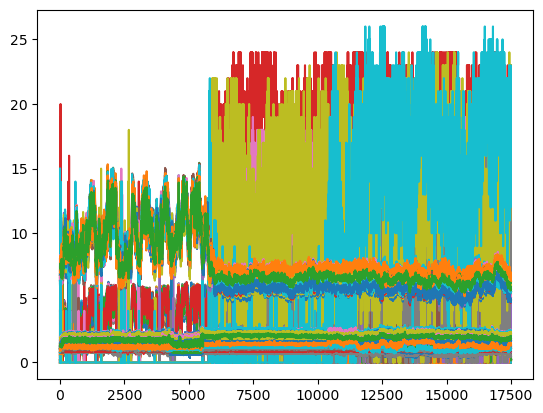

In [439]:
plt.plot(combined_features[0])

In [166]:
np.shape(top_features[0])

(17501, 12)

In [23]:
# Compute tICA on these top features
tica_combined = pyemma.coordinates.tica(data=combined_top_top, lag=50, dim=4)
tica_output = tica_combined.get_output()
top_cont = np.concatenate(tica_output)


calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

In [55]:
# Compute tICA on these top features
tica_combined = pyemma.coordinates.tica(data=combined_top_of_top_features, lag=100, dim=4)
tica_output_top_features = tica_combined.get_output()
top_cont = np.concatenate(tica_output_top_features)


NameError: name 'combined_top_of_top_features' is not defined

In [21]:
np.shape(top_cont)

(130963, 4)

In [22]:
np.shape(tica_combined.eigenvectors)

(63, 63)

In [23]:
np.shape(tica_combined.eigenvectors)

(63, 63)

In [8]:
# Number of ICs and top features to consider
n_ics = 4
n_top_features = 5

# Extract the ICs from tICA on combined features
ics_combined = tica_combined.eigenvectors[:n_ics]

# A dictionary to store weights and their indices
weights_dict_combined = {}

# Iterate over each IC
for i, ic in enumerate(ics_combined):
    # Get the indices of the top weights by magnitude
    top_indices = np.argsort(np.abs(ic))[-n_top_features:]
    
    # Update the dictionary with the new weights and indices
    for idx in top_indices:
        weights_dict_combined[idx] = ic[idx]

# Sort the dictionary by the magnitude of weights in descending order
sorted_weights_combined = sorted(weights_dict_combined.items(), key=lambda x: np.abs(x[1]), reverse=True)

# Map the indices back to the original arrays
length_arr1 = arr1[0].shape[1]  # Number of features in arr1
length_arr2 = arr2[0].shape[1]  # Number of features in arr2
length_arr3 = arr3[0].shape[1]  # Number of features in arr3
length_arr4 = arr4[0].shape[1]  # Number of features in arr4

for idx, weight in sorted_weights_combined:
    if idx < length_arr1:
        print(f"Feature comes from arr1, Index: {idx + 1}, Weight: {weight:.4f}")
    elif idx < (length_arr1 + length_arr2):
        print(f"Feature comes from arr2, Index: {idx - length_arr1 + 1}, Weight: {weight:.4f}")
    elif idx < (length_arr1 + length_arr2 + length_arr3):
        print(f"Feature comes from arr3, Index: {idx - length_arr1 - length_arr2 + 1}, Weight: {weight:.4f}")
    else:
        print(f"Feature comes from arr4, Index: {idx - length_arr1 - length_arr2 - length_arr3 + 1}, Weight: {weight:.4f}")


NameError: name 'tica_combined' is not defined

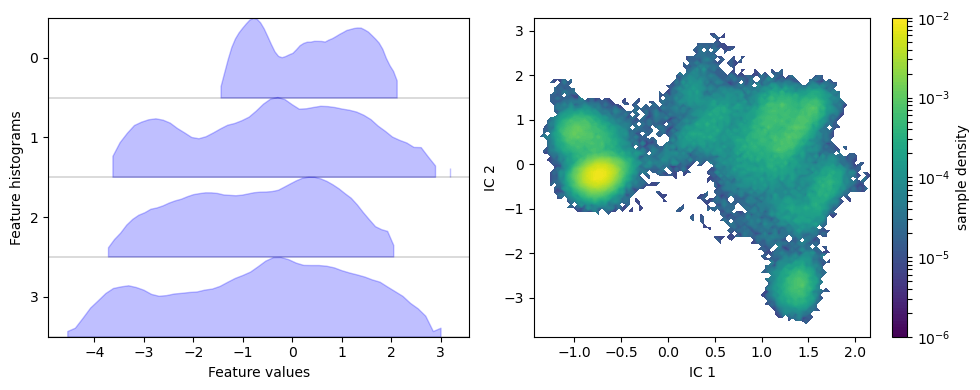

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    top_cont,
    ax=axes[0],
#     feature_labels=['IC1', 'IC2', 'IC3'],
    ylog=True, ignore_dim_warning=True)
pyemma.plots.plot_density(*top_cont[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()
# plt.savefig('tica_update.png', dpi= 300)

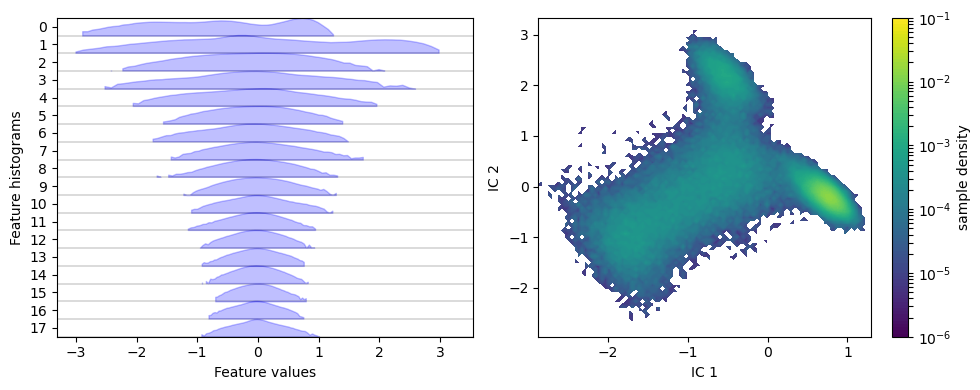

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
#     feature_labels=['IC1', 'IC2', 'IC3'],
    ylog=True, ignore_dim_warning=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()
# plt.savefig('tica_update.png', dpi= 300)

In [25]:
cluster = pyemma.coordinates.cluster_kmeans(
    tica_output, k=250, max_iter=200, stride=1, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)


initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

In [26]:
pwd

'/scratch/general/nfs1/u1266568/msm_v2.2/tica'

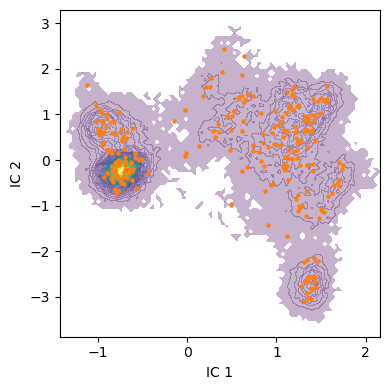

In [27]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *top_cont[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()
# plt.savefig('cluster_update.png',dpi=300)

estimating BayesianMSM:   0%|                                                                                 …

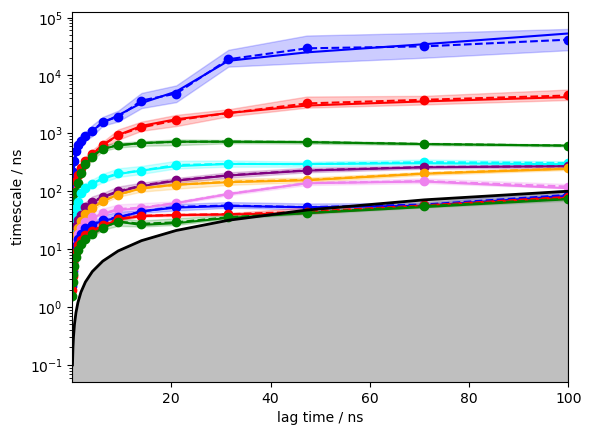

In [28]:
its = pyemma.msm.its(cluster.dtrajs, lags=1000, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1);
# plt.savefig('its_update.png',dpi=300)

In [29]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=440, dt_traj='0.1 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

pyemma.msm.estimators.bayesian_msm.BayesianMSM[87]: compute stat. inefficiencies:   0%|                       …

pyemma.msm.estimators.bayesian_msm.BayesianMSM[87]: Sampling MSMs:   0%|                                      …

fraction of states used = 1.00
fraction of counts used = 1.00


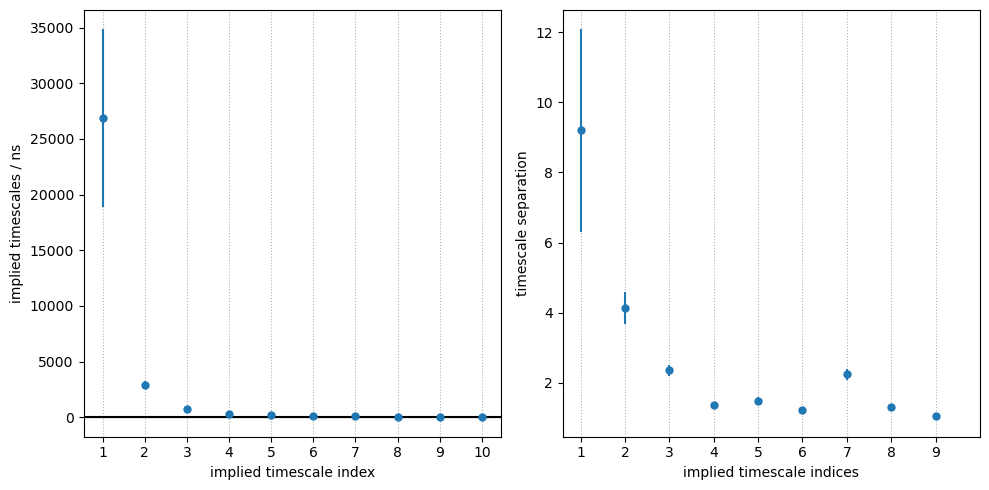

In [30]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 10

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean,
    yerr=timescales_std,
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:],
    yerr=its_separation_err(
        timescales_mean,
        timescales_std),
    fmt='.',
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')

axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
# axes[1].set_xticklabels(
#     ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
#     rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()
# plt.savefig('4state_spectral_update.png',dpi=300)

estimating BayesianMSM:   0%|                                                                                 …

/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 247 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 246 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 245 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/msmtools/analysis/api.py:

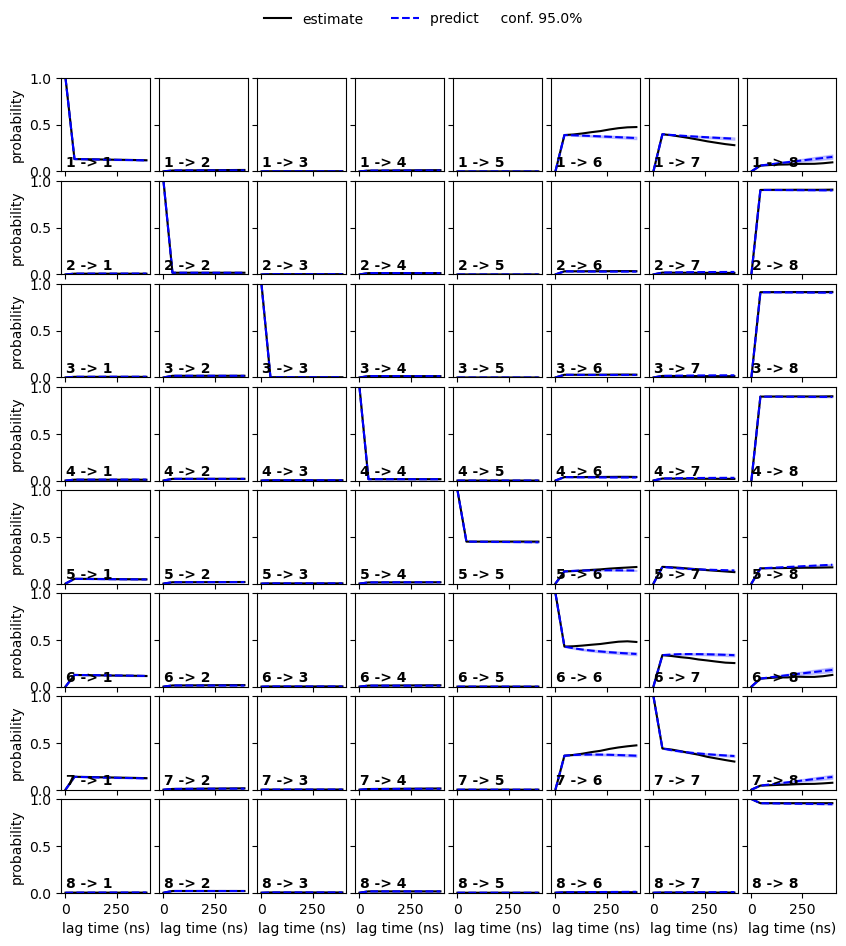

In [31]:
nstates = 8
cktest = msm.cktest(nstates)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns');
# plt.savefig('cktets.png',dpi = 300)

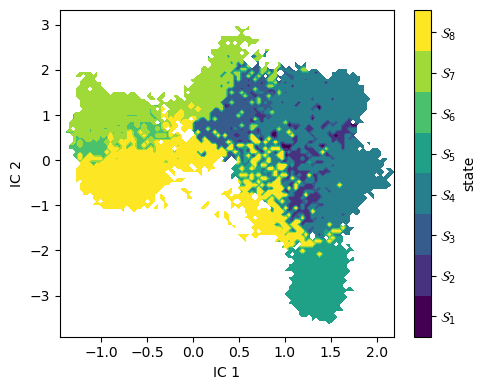

In [32]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *top_cont[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()
# fig.savefig('pcca_update.png',dpi=400)

# Assign the state

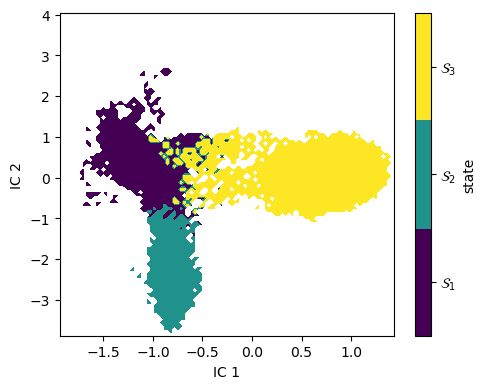

In [164]:
# Swap states 0 and 1 in metastable_traj
metastable_traj_swapped = np.where(metastable_traj == 0, -1, metastable_traj)  # temporarily label state 0 as -1
metastable_traj_swapped = np.where(metastable_traj_swapped == 1, 0, metastable_traj_swapped)  # label state 1 as 0
metastable_traj_swapped = np.where(metastable_traj_swapped == -1, 1, metastable_traj_swapped)  # label state -1 (old state 0) as 1

# Now plot with the swapped metastable_traj
fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj_swapped, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()
# fig.savefig('pcca_update_swapped.png', dpi=400)


In [35]:
# Swap states 1 and 2 in the metastable assignments
metastable_traj[metastable_traj == 0] = -1  # Temporarily set state 1 (0 in 0-based indexing) to -1
metastable_traj[metastable_traj == 1] = 0   # Set state 2 (1 in 0-based indexing) to 0 (state 1)
metastable_traj[metastable_traj == -1] = 1  # Set state -1 (which was originally 1) to 1 (state 2)


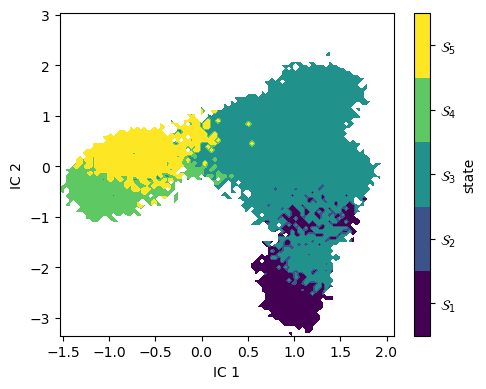

In [36]:

# State map plot
fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *top_cont[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()
# fig.savefig('pcca_update.png',dpi=400)


In [121]:
import pyemma.plots as mplt


<Axes: >

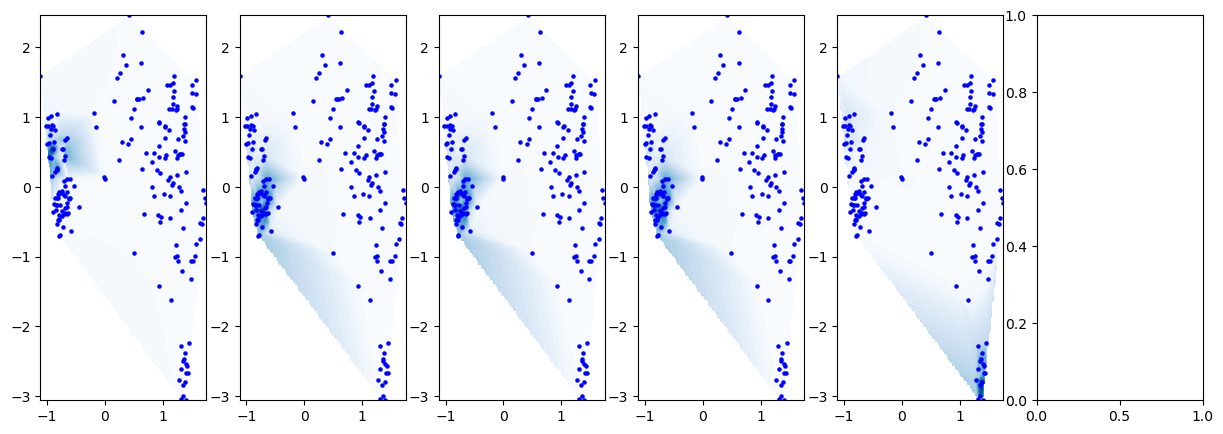

In [123]:
msm.pcca(8)
pcca_dist = msm.metastable_distributions

f, (ax1, ax2, ax3,ax4,ax5,ax6) = plt.subplots(ncols=6)
f.set_size_inches(15, 5)

cmap = plt.cm.Blues

# Extract cluster center coordinates from the 'cluster' object
cc_x = cluster.clustercenters[:, 0]
cc_y = cluster.clustercenters[:, 1]

mplt.scatter_contour(cc_x, cc_y, pcca_dist[0], fig=f, ax=ax1, colorbar=False, cmap=cmap)
mplt.scatter_contour(cc_x, cc_y, pcca_dist[1], fig=f, ax=ax2, colorbar=False, cmap=cmap)
mplt.scatter_contour(cc_x, cc_y, pcca_dist[2], fig=f, ax=ax3, colorbar=False, cmap=cmap)
mplt.scatter_contour(cc_x, cc_y, pcca_dist[3], fig=f, ax=ax4, colorbar=False, cmap=cmap)
mplt.scatter_contour(cc_x, cc_y, pcca_dist[4], fig=f, ax=ax5, colorbar=False, cmap=cmap)
# mplt.scatter_contour(cc_x, cc_y, pcca_dist[5], fig=f, ax=ax6, colorbar=False, cmap=cmap)


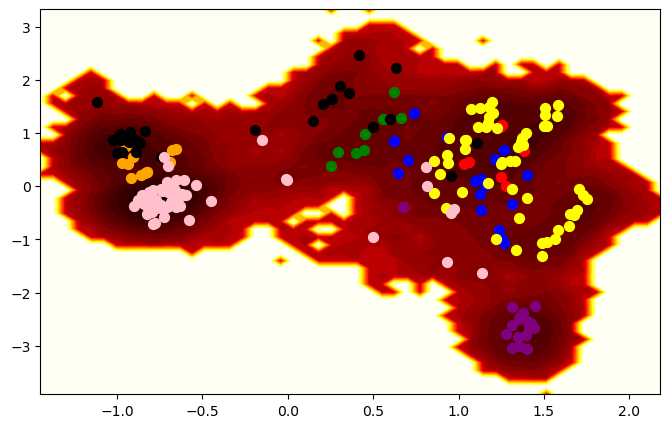

In [125]:
# Calculate the 2D histogram from your TICA data
z, x, y = np.histogram2d(top_cont[:, 0], top_cont[:, 1], bins=50)

# Compute the free energies
F = -np.log(z + 1e-10)  # Added a small constant to avoid log(0)

# Define the extent
extent = [x[0], x[-1], y[0], y[-1]]

# Sample by metastable distributions
pcca_samples = msm.sample_by_distributions(pcca_dist, 100)

# Extract metastable sets
pcca_sets = msm.metastable_sets

# Create a figure
plt.figure(figsize=(8, 5))

# Contour plot of the free energy surface
plt.contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)

# Scatter plot the cluster centers for each metastable state
plt.scatter(cluster.clustercenters[pcca_sets[0], 0], cluster.clustercenters[pcca_sets[0], 1], color='red', s=50)
plt.scatter(cluster.clustercenters[pcca_sets[1], 0], cluster.clustercenters[pcca_sets[1], 1], color='blue', s=50)
plt.scatter(cluster.clustercenters[pcca_sets[2], 0], cluster.clustercenters[pcca_sets[2], 1], color='green', s=50)
plt.scatter(cluster.clustercenters[pcca_sets[3], 0], cluster.clustercenters[pcca_sets[3], 1], color='yellow', s=50)
plt.scatter(cluster.clustercenters[pcca_sets[4], 0], cluster.clustercenters[pcca_sets[4], 1], color='purple', s=50)
plt.scatter(cluster.clustercenters[pcca_sets[5], 0], cluster.clustercenters[pcca_sets[5], 1], color='orange', s=50)
plt.scatter(cluster.clustercenters[pcca_sets[6], 0], cluster.clustercenters[pcca_sets[6], 1], color='black', s=50)
plt.scatter(cluster.clustercenters[pcca_sets[7], 0], cluster.clustercenters[pcca_sets[7], 1], color='pink', s=50)


plt.show()


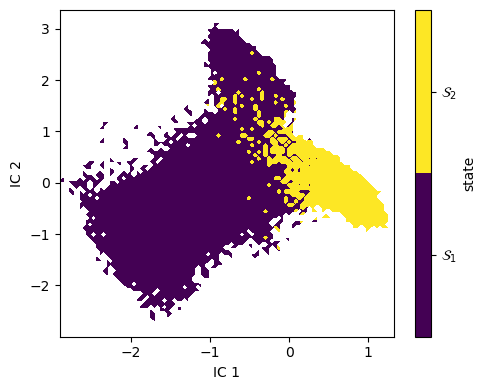

In [66]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()
# fig.savefig('pcca_update.png',dpi=400)

NameError: name 'tica_concatenated' is not defined

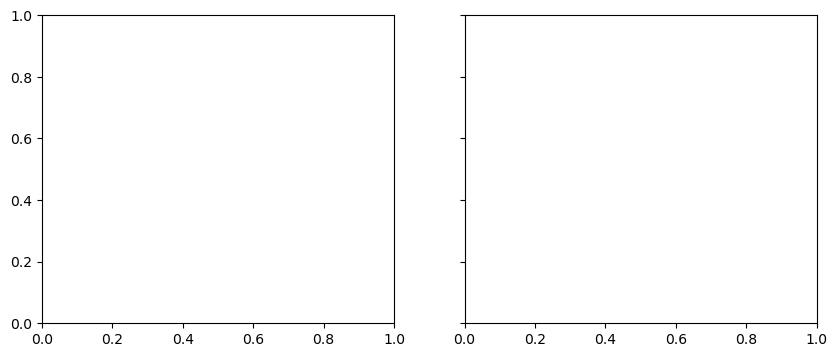

In [137]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()
# plt.savefig('macro_energy_update.png',dpi=400)

/tmp/ipykernel_4040051/156789612.py:12: RuntimeWarning: divide by zero encountered in log
  fes_kBT = -np.log(hist)


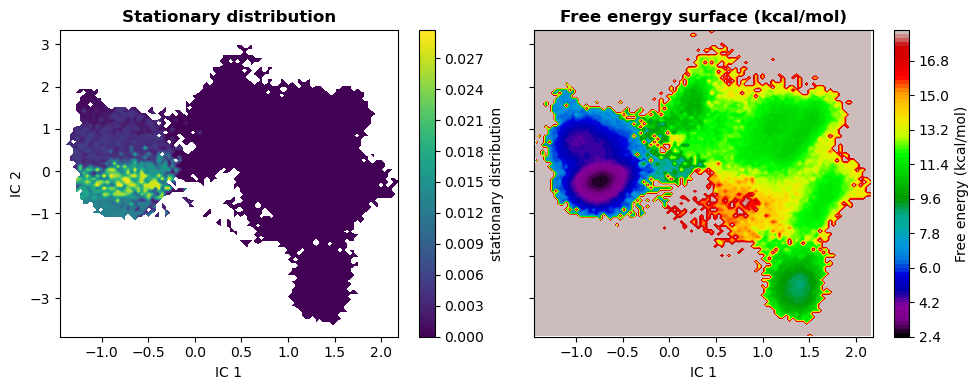

In [34]:
# Compute 2D histogram
kB=1.987e-3
T=310
hist, xedges, yedges = np.histogram2d(
    top_cont[:, 0], top_cont[:, 1], 
    bins=100, weights=np.concatenate(msm.trajectory_weights()))

# Convert histogram to probability
hist /= hist.sum()

# Convert probabilities to free energy in units of kBT
fes_kBT = -np.log(hist)

# Handle infinities
fes_kBT[np.isinf(fes_kBT)] = fes_kBT[~np.isinf(fes_kBT)].max()

# Convert the free energy to kcal/mol
fes_kcal_per_mol = fes_kBT * kB * T

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Plot stationary distribution
pyemma.plots.plot_contour(
    *top_cont[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')

# Plot free energy in kcal/mol
contourf = axes[1].contourf(
    (xedges[:-1] + xedges[1:]) / 2,
    (yedges[:-1] + yedges[1:]) / 2,
    fes_kcal_per_mol.T,  # transpose due to how meshgrid works
    levels=100,  # you can adjust the number of levels or provide explicit levels
    cmap='nipy_spectral'
)
cbar = fig.colorbar(contourf, ax=axes[1])
cbar.set_label('Free energy (kcal/mol)')

for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Free energy surface (kcal/mol)', fontweight='bold')
fig.tight_layout()
# plt.savefig('4state_pmf.png',dpi=400)


In [35]:
print('state\tπ\t\tG/kT')
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    print('{}\t{:f}\t{:f}'.format(i + 1, p, -np.log(p)))

state	π		G/kT
1	0.000000	20.355284
2	0.000000	15.026769
3	0.000001	14.220364
4	0.000007	11.873854
5	0.000039	10.154437
6	0.054980	2.900790
7	0.055176	2.897229
8	0.889798	0.116761


#  DEV

In [36]:
# Swap the metastable sets for states 0 and 1
msm.metastable_sets[0], msm.metastable_sets[1] = msm.metastable_sets[1], msm.metastable_sets[0]

# Now, when you compute properties or make plots, states 0 and 1 will be swapped
print('state\tπ\t\tG/kT')
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    print('{}\t{:f}\t{:f}'.format(i + 1, p, -np.log(p)))


state	π		G/kT
1	0.000000	15.026769
2	0.000000	20.355284
3	0.000001	14.220364
4	0.000007	11.873854
5	0.000039	10.154437
6	0.054980	2.900790
7	0.055176	2.897229
8	0.889798	0.116761


In [37]:
from itertools import product

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / ns:


,1,2,3,4,5,6,7,8
1,0.000000e+00,6.830562e+10,3.640156e+08,78322228.42,5.409310e+08,4587.83,2649.85,3800.13
2,5.762804e+07,0.000000e+00,3.563639e+08,59805721.86,5.336237e+08,8488.36,8196.94,3627.29
3,8.505881e+08,6.947403e+10,0.000000e+00,31674533.39,5.325406e+08,17345.39,21521.45,1924.19
4,8.652680e+08,6.947749e+10,3.314010e+08,0.00,5.322616e+08,19207.92,24084.53,1881.18
5,8.644970e+08,6.948835e+10,3.661768e+08,61436168.96,0.000000e+00,43676.19,49923.16,21963.77
6,8.793367e+08,6.951050e+10,3.922859e+08,92484150.94,5.614130e+08,0.00,4540.11,3059.58
7,8.793308e+08,6.951049e+10,3.922841e+08,92482898.62,5.614127e+08,400.84,0.00,3338.26
8,8.793577e+08,6.951051e+10,3.922915e+08,92487750.34,5.614124e+08,22459.31,29454.92,0.00


In [176]:
# Extract the original transition matrix
original_matrix = msm.transition_matrix

# Create a swapped transition matrix
swapped_matrix = original_matrix.copy()

# Swap rows 0 and 1
swapped_matrix[[0, 1], :] = swapped_matrix[[1, 0], :]

# Swap columns 0 and 1
swapped_matrix[:, [0, 1]] = swapped_matrix[:, [1, 0]]

# Now, you have both the original and swapped matrices.
# To compare them, you can print them, or compute some metric (e.g., Frobenius norm of their difference).
difference = np.linalg.norm(original_matrix - swapped_matrix, 'fro')

print("Original Matrix:\n", original_matrix)
print("\nSwapped Matrix:\n", swapped_matrix)
print("\nDifference (Frobenius norm):", difference)


Original Matrix:
 [[8.88178420e-16 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.12734843e-02]
 [0.00000000e+00 1.41843971e-02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.64451832e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.24344568e-02
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.42465752e-02 7.49135518e-03]
 [9.46053101e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.12739276e-03 6.66666665e-03]]

Swapped Matrix:
 [[1.41843971e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.88178420e-16 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.12734843e-02]
 [0.00000000e+00 0.00000000e+00 6.64451832e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.24344568e

In [152]:
print('state\tπ\t\tG (kcal/mol)')
kT = 0.61593626  # Boltzmann's constant at 310 K in kcal/mol
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    G_kcal_per_mol = -kT * np.log(p)
    print('{}\t{:f}\t{:f}'.format(i + 1, p, G_kcal_per_mol))


state	π		G (kcal/mol)
1	0.000018	6.736689
2	0.000065	5.934808
3	0.999917	0.000051


In [169]:
from itertools import product

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / ns:


,1,2,3
1,0.00,744037.51,2053.00
2,56937840.90,0.00,897.66
3,67827013.82,11372518.12,0.00


state	π		G/kT
2	0.000065	9.635426
1	0.000018	10.937315
3	0.999917	0.000083


# Accounting for change of states:

In [42]:
from itertools import product
import numpy as np
from pandas import DataFrame

nstates = 5
mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

# Swap states 1 and 2 in the MFPT matrix
mfpt[[0, 1]] = mfpt[[1, 0]]  # Swap rows
mfpt[:, [0, 1]] = mfpt[:, [1, 0]]  # Swap columns

print('MFPT / ns:')
print(DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1)))


MFPT / ns:
              1             2        3         4        5
1  0.000000e+00  1.428619e+08   485.33  13030.60  4616.74
2  3.714068e+07  0.000000e+00   136.45  13772.60  4731.95
3  1.843913e+08  3.813658e+08     0.00   2997.22  3064.48
4  1.844525e+08  3.814558e+08   467.62      0.00  3795.02
5  1.844581e+08  3.814600e+08  6232.70  16853.72     0.00


In [403]:
n_macrostates = 3  # or however many macrostates you have
mapping = {0: 0, 1: 2, 2: 1}  # map old states to new states

# Create a new assignment of microstates to macrostates
new_assignment = np.zeros_like(msm.metastable_assignments)
for i in range(n_macrostates):
    new_assignment[msm.metastable_assignments == i] = mapping[i]

# Replace the old assignments with the new ones
# msm.metastable_assignments = new_assignment

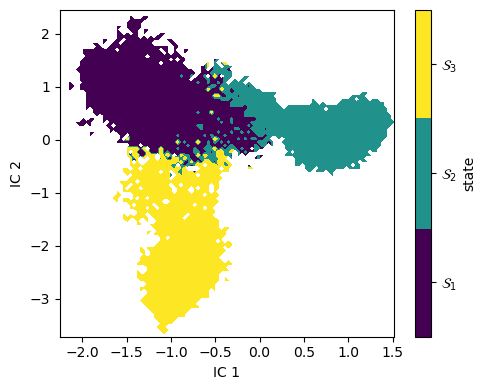

In [404]:
metastable_traj = new_assignment[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *top_cont[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()
# fig.savefig('pcca_update.png',dpi=400)

In [405]:
# Compute MFPTs between all pairs of new PCCA+ states
mfpts = np.zeros((len(mapping), len(mapping)))
for i in range(len(mapping)):
    for j in range(len(mapping)):
        if i != j:
            mfpts[i, j] = msm.mfpt(
                msm.metastable_sets[new_assignment[i]],
                msm.metastable_sets[new_assignment[j]]
            )

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / ns:


,1,2,3
1,0.00,1.767473e+08,1523.11
2,5140744.41,0.000000e+00,29153.94
3,11383181.46,1.832675e+08,0.00


# Overlay the network

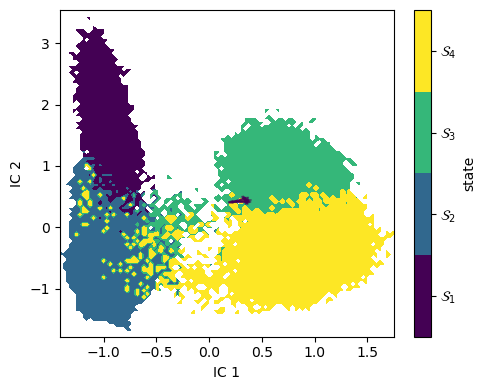

In [136]:
# Compute centroids of metastable sets
centroids = np.zeros((nstates, 2))
for i, s in enumerate(msm.metastable_sets):
    centroids[i] = np.mean(tica_concatenated[s, :2], axis=0)

# Create the PCCA plot
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)

# Draw arrows based on MFPT
for i, j in product(range(nstates), repeat=2):
    if i != j:
        ax.arrow(centroids[i, 0], centroids[i, 1], 
                 centroids[j, 0] - centroids[i, 0], 
                 centroids[j, 1] - centroids[i, 1], 
                 alpha=0.5, width=0.01, 
                 color=plt.cm.viridis(1.0/mfpt[i,j]))

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()
# fig.savefig('pcca_update_with_mfpt.png',dpi=400)


In [140]:
# Compute centroids of metastable sets
centroids = np.zeros((nstates, 2))
for i, s in enumerate(msm.metastable_sets):
    centroids[i] = np.mean(tica_concatenated[s, :2], axis=0)
print("Centroids:", centroids)


Centroids: [[0.35350201 0.41275638]
 [0.22638784 0.41321376]
 [0.33496535 0.46813259]
 [0.3586342  0.43710795]]


In [144]:
# Directly calculate centroids based on metastable assignments
centroids = np.array([tica_concatenated[metastable_traj == i].mean(axis=0) 
                      for i in range(nstates)])
print("Centroids:", centroids)


Centroids: [[-9.8643702e-01  1.7427005e+00  9.8702794e-01  1.9532537e-02
  -4.0098831e-02  1.9104637e-02  3.6784381e-02 -3.0163933e-02
  -2.0590913e-02  7.9732919e-03 -1.1601642e-02]
 [-1.0534618e+00 -6.1109686e-01 -2.6962179e-01  4.2232718e-02
   4.3523512e-03 -1.8255463e-02 -6.8739980e-02 -5.7877265e-03
   1.0146887e-02 -2.3120322e-04 -1.1681436e-02]
 [ 6.6133064e-01  8.1872624e-01 -1.4632996e+00 -2.5769043e-01
  -1.4328860e-02  1.8138366e-02 -6.6837152e-03 -1.9905364e-04
   1.8962250e-03  3.0037446e-03 -1.9113152e-04]
 [ 8.1707746e-01 -3.1674343e-01  4.8464730e-01  1.0213224e-01
  -5.7490491e-03  2.5415034e-03  1.3582547e-02  9.2003774e-03
   1.2298470e-02 -4.9306178e-03  3.2821372e-03]]


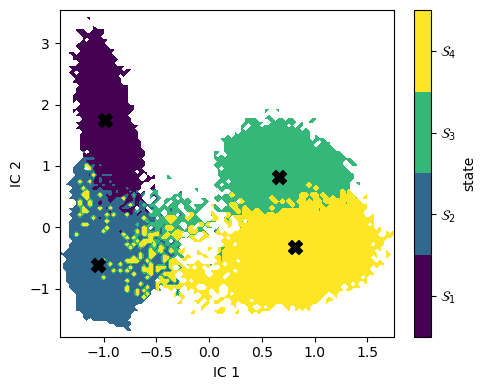

In [145]:
fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)

# Plot centroids as large markers
ax.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', marker='X', label='Centroids')

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()


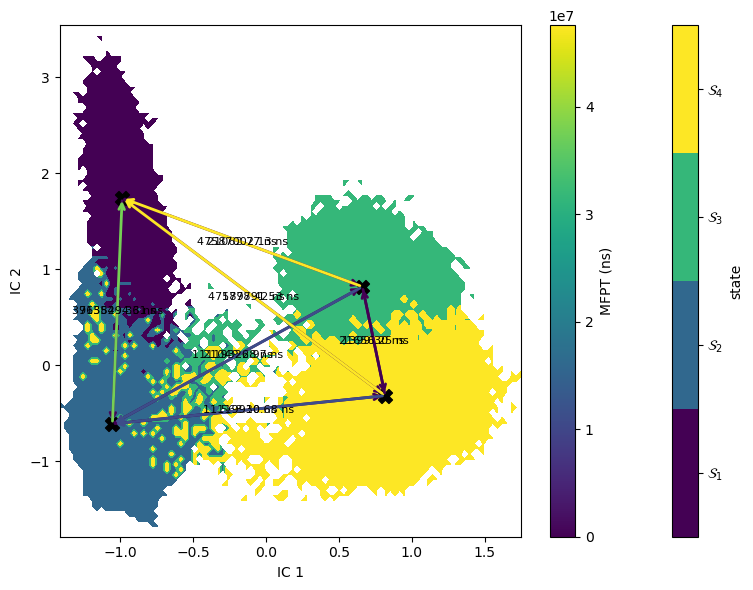

In [148]:
fig, ax = plt.subplots(figsize=(8, 6))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)

# Plot centroids as large markers
ax.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', marker='X', label='Centroids')

# Normalize the MFPT values for color mapping
norm_mfpt = plt.Normalize(vmin=0, vmax=mfpt.max())

# Draw arrows based on MFPT and label them with MFPT values
for i, j in product(range(nstates), repeat=2):
    if i != j:
        # Draw arrow
        ax.annotate("",
                    xy=centroids[j, :2], 
                    xytext=centroids[i, :2],
                    arrowprops=dict(arrowstyle="->",
                                    lw=2,
                                    color=plt.cm.viridis(norm_mfpt(mfpt[i, j]))),
                    )
        
        # Annotate arrow with MFPT value
        mid_point = (centroids[i] + centroids[j]) / 2
        ax.text(mid_point[0], mid_point[1], f"{mfpt[i, j]:.2f} ns", 
                ha="center", va="center", fontsize=8, color="black")

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm_mfpt, cmap='viridis'), ax=ax)
cbar.set_label('MFPT (ns)')

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()


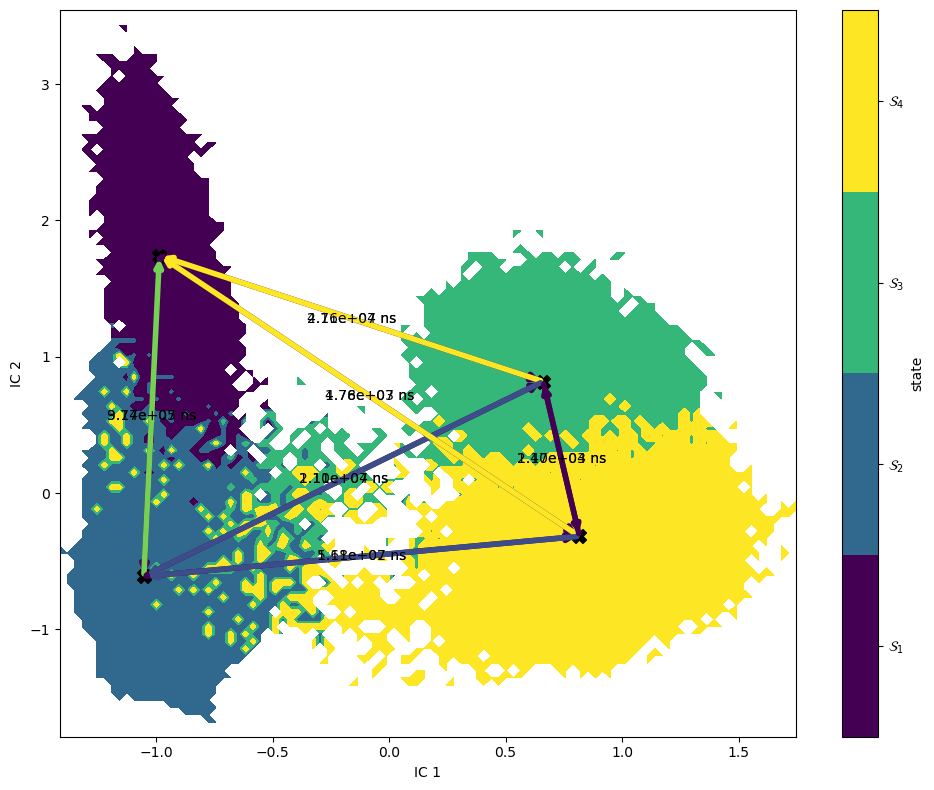

In [153]:
fig, ax = plt.subplots(figsize=(10, 8))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)

# Plot centroids as large markers
ax.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', marker='X', label='Centroids')

# Draw arrows based on MFPT and label them with MFPT values
for i, j in product(range(nstates), repeat=2):
    if i != j:
        # Draw arrow
        ax.annotate("",
                    xy=centroids[j, :2], 
                    xytext=centroids[i, :2],
                    arrowprops=dict(arrowstyle="->",
                                    lw=4,  # thicker lines
                                    color=plt.cm.viridis(norm_mfpt(mfpt[i, j]))),
                    )
        
        # Annotate arrow with MFPT value in scientific notation
        mid_point = (centroids[i] + centroids[j]) / 2
        ax.text(mid_point[0], mid_point[1], f"{mfpt[i, j]:.2e} ns", 
                ha="center", va="center", fontsize=10, color="black")  # bigger text size

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()


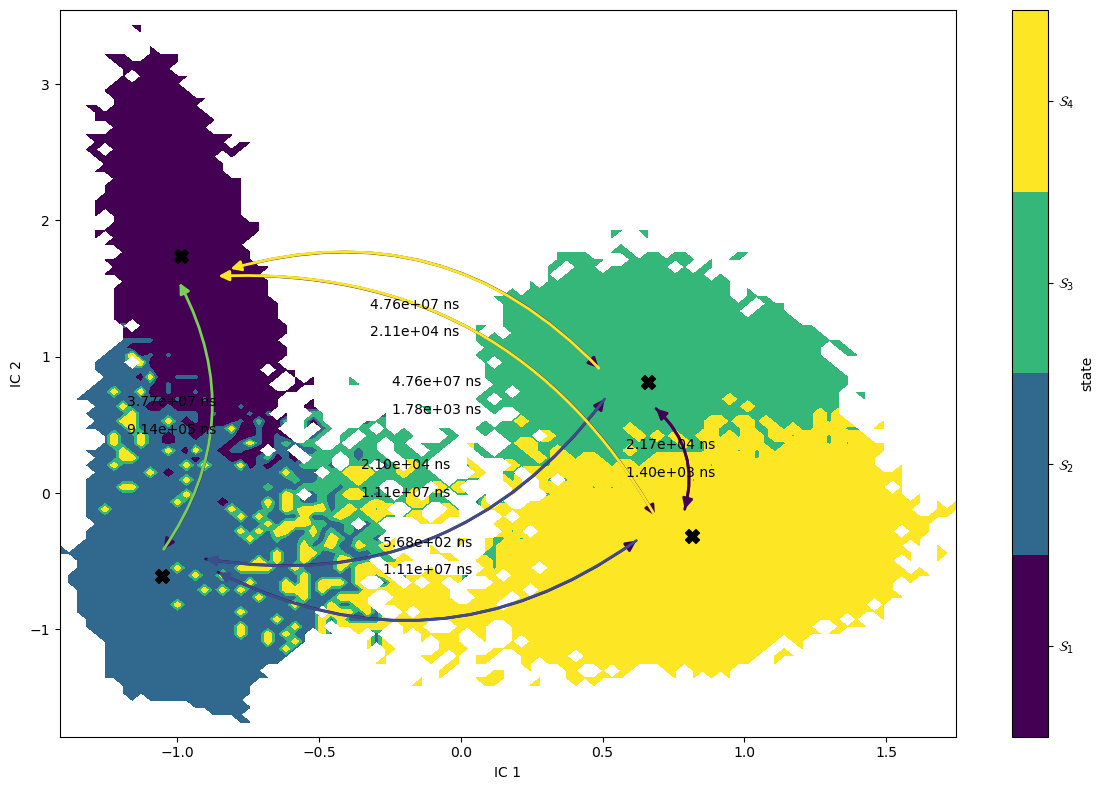

In [178]:
from matplotlib.patches import ConnectionPatch

fig, ax = plt.subplots(figsize=(12, 8))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)

# Plot centroids as large markers
ax.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', marker='X', label='Centroids')

arrow_offset = 0.2  # distance from centroid to start/end of arrow
text_offset = 0.1   # distance from mid-point of arrow to place text

# Draw curved arrows and label them with MFPT values
for i, j in product(range(nstates), repeat=2):
    if i != j:
        # Calculate start and end points of the arrow, so they don't touch centroids directly
        direction = centroids[j, :2] - centroids[i, :2]  # Only use the first two dimensions
        direction /= np.linalg.norm(direction)
        start_point = centroids[i, :2] + arrow_offset * direction  # Only use the first two dimensions
        end_point = centroids[j, :2] - arrow_offset * direction  # Only use the first two dimensions
        
        # Determine curvature direction (upward or downward) based on ICs
        if centroids[j, 1] > centroids[i, 1]:
            curve_direction = "top"
        else:
            curve_direction = "bottom"
        
        # Draw curved arrow
        cp = ConnectionPatch(start_point, end_point, coordsA="data", coordsB="data",
                             arrowstyle="-|>", mutation_scale=15, lw=2,
                             connectionstyle=f"arc3,rad={0.3 if curve_direction == 'top' else -0.3}",
                             color=plt.cm.viridis(norm_mfpt(mfpt[i, j])))
        ax.add_patch(cp)
        
        # Annotate arrow with MFPT value in scientific notation
        mid_point = (start_point + end_point) / 2
        if curve_direction == "top":
            ax.text(mid_point[0], mid_point[1] + text_offset, f"{mfpt[i, j]:.2e} ns", 
                    ha="center", va="center", fontsize=10, color="black")
        else:
            ax.text(mid_point[0], mid_point[1] - text_offset, f"{mfpt[i, j]:.2e} ns", 
                    ha="center", va="center", fontsize=10, color="black")

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1) for i in range(nstates)])
fig.tight_layout()


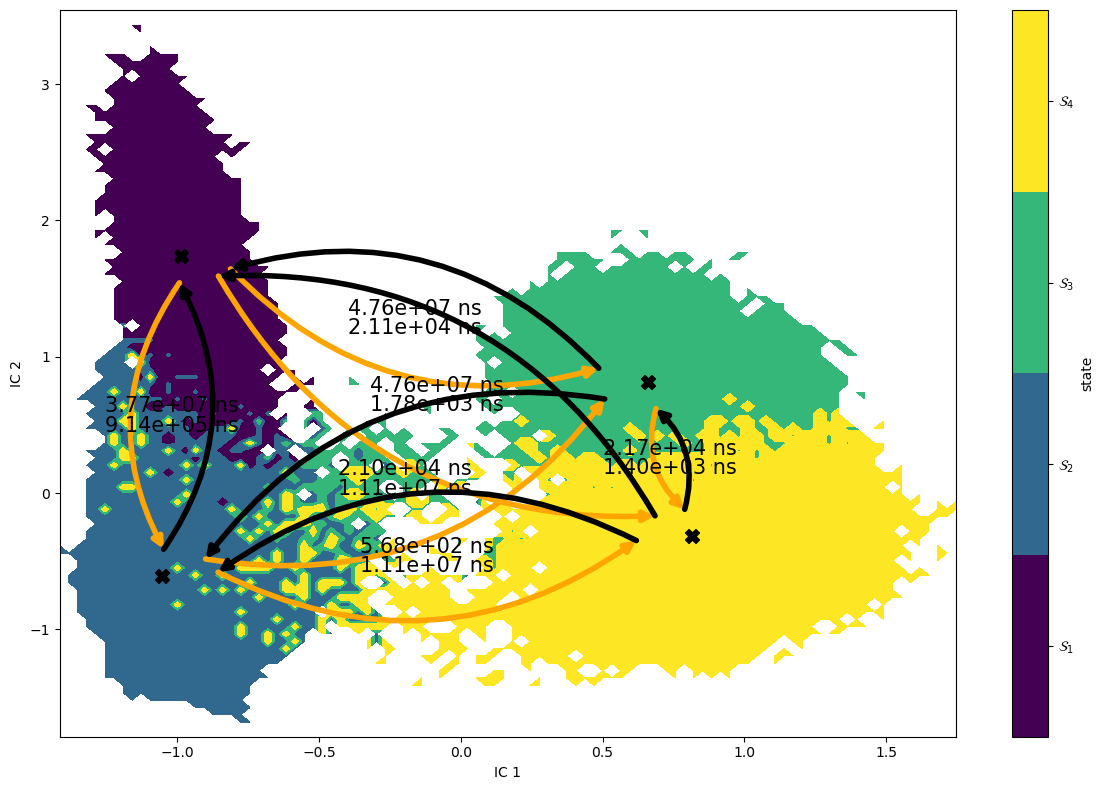

In [173]:
from matplotlib.patches import ConnectionPatch

fig, ax = plt.subplots(figsize=(12, 8))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)

# Plot centroids as large markers
ax.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', marker='X', label='Centroids')

arrow_offset = 0.2  # distance from centroid to start/end of arrow

# Draw curved arrows and label them with MFPT values
for i, j in product(range(nstates), repeat=2):
    if i != j:
        # Calculate start and end points of the arrow, so they don't touch centroids directly
        direction = centroids[j, :2] - centroids[i, :2]
        direction /= np.linalg.norm(direction)
        start_point = centroids[i, :2] + arrow_offset * direction
        end_point = centroids[j, :2] - arrow_offset * direction
        
        # Determine arrow color and curvature magnitude
        if i < j:
            arrow_color = "orange"
            rad_value = 0.3
        else:
            arrow_color = "black"
            rad_value = 0.3
        
        # Draw curved arrow
        cp = ConnectionPatch(start_point, end_point, coordsA="data", coordsB="data",
                             arrowstyle="-|>", mutation_scale=15, lw=4,
                             connectionstyle=f"arc3,rad={rad_value}",
                             color=arrow_color)
        ax.add_patch(cp)
        
        # Annotate arrow with MFPT value in scientific notation
        mid_point = (start_point + end_point) / 2

        # Determine text position based on the relative y-coordinates of the states
        if centroids[i, 1] < centroids[j, 1]:  # Arrow is pointing upwards
            text_position = (mid_point[0], mid_point[1] + 0.07)
        else:  # Arrow is pointing downwards
            text_position = (mid_point[0], mid_point[1] - 0.07)
        
        ax.text(*text_position, f"{mfpt[i, j]:.2e} ns", 
                ha="center", va="center", fontsize=15, color="black")

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1) for i in range(nstates)])
fig.tight_layout()


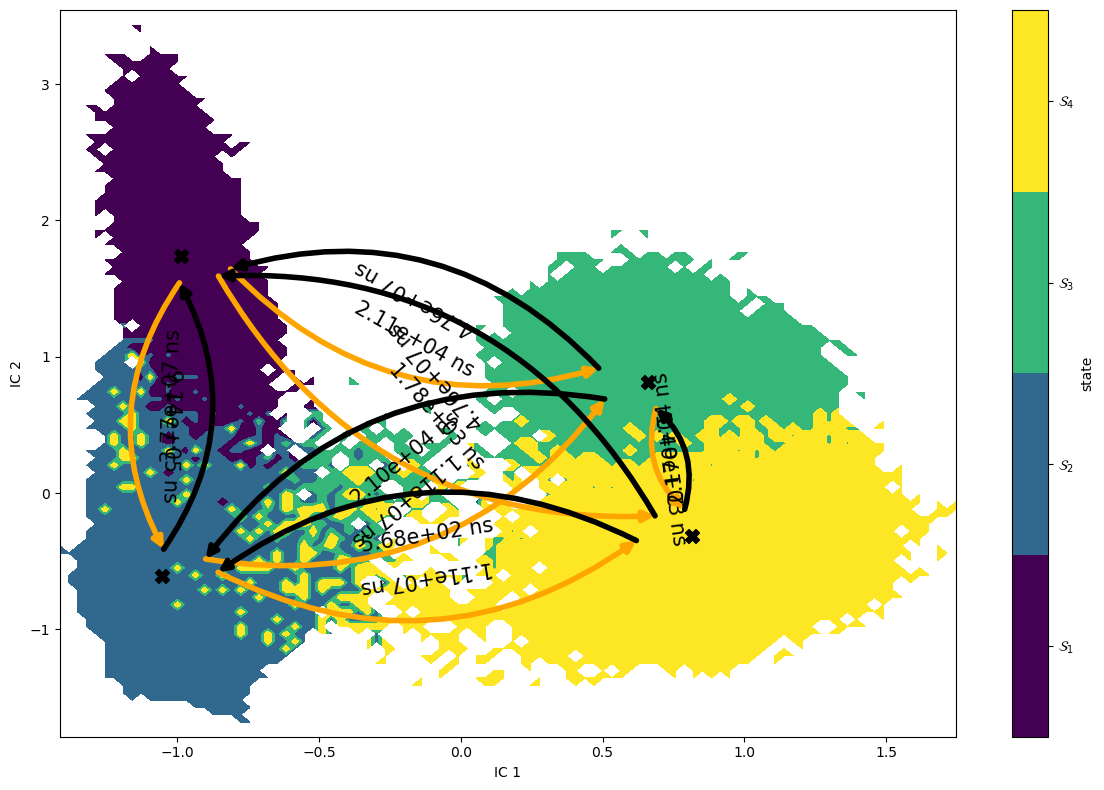

In [177]:
from matplotlib.patches import ConnectionPatch
import numpy as np

fig, ax = plt.subplots(figsize=(12, 8))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)

# Plot centroids as large markers
ax.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', marker='X', label='Centroids')

arrow_offset = 0.2  # distance from centroid to start/end of arrow
arc_apex_offset = 0.15  # factor to compute the arc's apex along the arrow's direction

# Draw curved arrows and label them with MFPT values
for i, j in product(range(nstates), repeat=2):
    if i != j:
        # Calculate start and end points of the arrow, so they don't touch centroids directly
        direction = centroids[j, :2] - centroids[i, :2]
        direction /= np.linalg.norm(direction)
        start_point = centroids[i, :2] + arrow_offset * direction
        end_point = centroids[j, :2] - arrow_offset * direction
        
        # Determine arrow color and curvature magnitude
        if i < j:
            arrow_color = "orange"
            rad_value = 0.3
        else:
            arrow_color = "black"
            rad_value = 0.3
        
        # Draw curved arrow
        cp = ConnectionPatch(start_point, end_point, coordsA="data", coordsB="data",
                             arrowstyle="-|>", mutation_scale=15, lw=4,
                             connectionstyle=f"arc3,rad={rad_value}",
                             color=arrow_color)
        ax.add_patch(cp)
        
        # Compute the arc's apex for placing the timescale text
        mid_point = (start_point + end_point) / 2

        # Adjust the position slightly above or below depending on the arrow direction
        if centroids[i, 1] < centroids[j, 1]:  # Arrow is pointing upwards
            text_position = (mid_point[0], mid_point[1] + arc_apex_offset)
        else:  # Arrow is pointing downwards
            text_position = (mid_point[0], mid_point[1] - arc_apex_offset)
        
        # Calculate the angle of the arrow
        dy = end_point[1] - start_point[1]
        dx = end_point[0] - start_point[0]
        angle = np.degrees(np.arctan2(dy, dx))

        ax.text(text_position[0], text_position[1], f"{mfpt[i, j]:.2e} ns", 
                ha="center", va="center", fontsize=15, color="black", rotation=angle, rotation_mode='anchor')

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1) for i in range(nstates)])
fig.tight_layout()


NameError: name 'file_path' is not defined

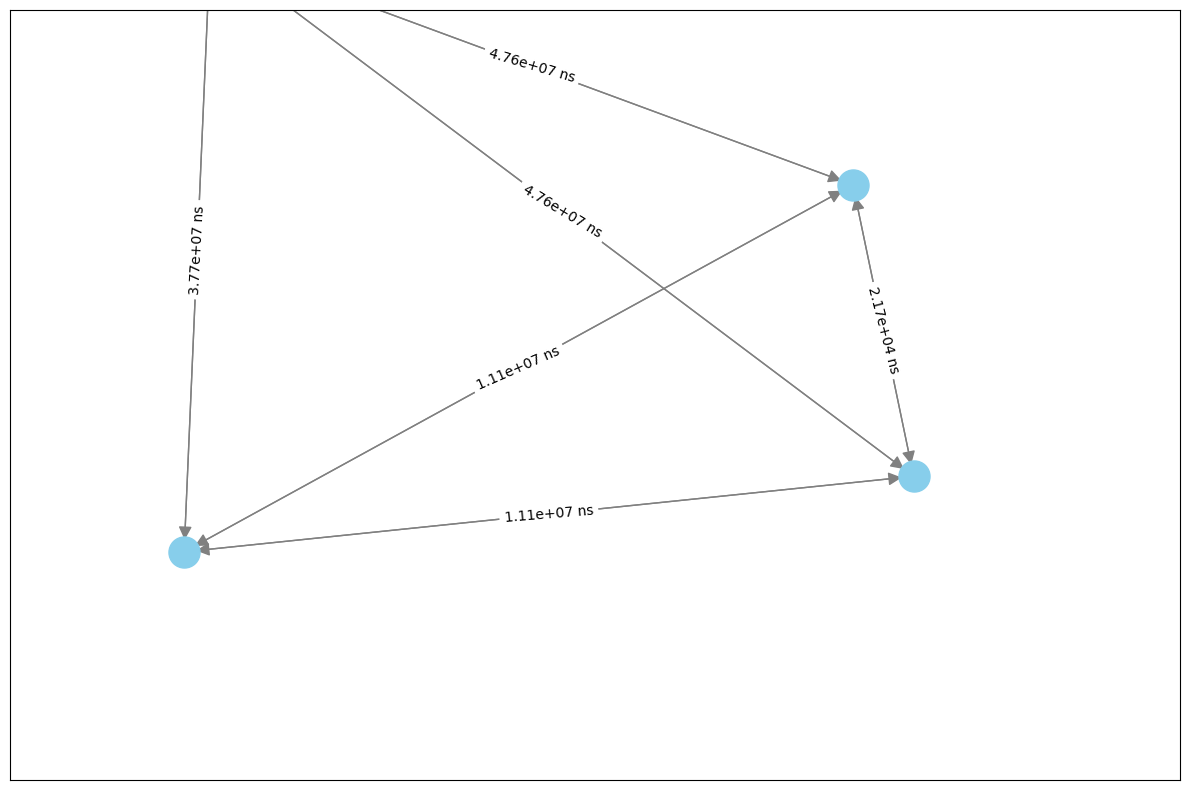

In [181]:
import networkx as nx

# Create a directed graph using NetworkX
G = nx.DiGraph()

# Add nodes for each metastable state
for i in range(nstates):
    G.add_node(i, pos=centroids[i, :2])

# Add edges with MFPT values
for i, j in product(range(nstates), repeat=2):
    if i != j:
        G.add_edge(i, j, weight=mfpt[i, j])

fig, ax = plt.subplots(figsize=(12, 8))

# Node positions are based on the centroids
pos = nx.get_node_attributes(G, 'pos')

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue', ax=ax)

# Draw the edges with weights (MFPT values)
labels = {(i, j): f"{G[i][j]['weight']:.2e} ns" for i, j in G.edges()}
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20, edge_color='grey', ax=ax)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

# Saving the plot
fig.tight_layout()
fig.savefig(file_path, dpi=400)

file_path


# Extract structures

In [56]:
import os

path = '../../adaptive_sampling_trajs/send/'
files1 = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.xtc')]

for file in files1:
    print(file)


../../adaptive_sampling_trajs/send/10.xtc
../../adaptive_sampling_trajs/send/1.xtc
../../adaptive_sampling_trajs/send/34.xtc
../../adaptive_sampling_trajs/send/33.xtc
../../adaptive_sampling_trajs/send/32.xtc
../../adaptive_sampling_trajs/send/35.xtc
../../adaptive_sampling_trajs/send/31.xtc
../../adaptive_sampling_trajs/send/15.xtc
../../adaptive_sampling_trajs/send/20.xtc
../../adaptive_sampling_trajs/send/5.xtc
../../adaptive_sampling_trajs/send/30.xtc


In [92]:
path = '../../adaptive_sampling_trajs/round2/'
files2 = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.xtc')]

for file in files2:
    print(file)

../../adaptive_sampling_trajs/round2/1.xtc
../../adaptive_sampling_trajs/round2/2.xtc
../../adaptive_sampling_trajs/round2/3.xtc
../../adaptive_sampling_trajs/round2/4.xtc
../../adaptive_sampling_trajs/round2/5.xtc
../../adaptive_sampling_trajs/round2/6.xtc
../../adaptive_sampling_trajs/round2/7.xtc
../../adaptive_sampling_trajs/round2/8.xtc
../../adaptive_sampling_trajs/round2/9.xtc
../../adaptive_sampling_trajs/round2/10.xtc


In [89]:
tlist=['../../trajdat/dat2/rep1_tot.xtc','../../trajdat/dat2/rep2_tot.xtc','../../trajdat/dat2/rep3_tot.xtc',\
       '../../trajdat/dat2/rep4.xtc','../../trajdat/dat2/rep6_tot2.xtc','../../trajdat/dat/1_tot.xtc','../../trajdat/dat/3_tot.xtc',\
        '../../trajdat/dat/5_tot.xtc','../../trajdat/dat/9_tot.xtc']

In [96]:
total = tlist+files2+files1

In [97]:
total

['../../trajdat/dat2/rep1_tot.xtc',
 '../../trajdat/dat2/rep2_tot.xtc',
 '../../trajdat/dat2/rep3_tot.xtc',
 '../../trajdat/dat2/rep4.xtc',
 '../../trajdat/dat2/rep6_tot2.xtc',
 '../../trajdat/dat/1_tot.xtc',
 '../../trajdat/dat/3_tot.xtc',
 '../../trajdat/dat/5_tot.xtc',
 '../../trajdat/dat/9_tot.xtc',
 '../../adaptive_sampling_trajs/round2/1.xtc',
 '../../adaptive_sampling_trajs/round2/2.xtc',
 '../../adaptive_sampling_trajs/round2/3.xtc',
 '../../adaptive_sampling_trajs/round2/4.xtc',
 '../../adaptive_sampling_trajs/round2/5.xtc',
 '../../adaptive_sampling_trajs/round2/6.xtc',
 '../../adaptive_sampling_trajs/round2/7.xtc',
 '../../adaptive_sampling_trajs/round2/8.xtc',
 '../../adaptive_sampling_trajs/round2/9.xtc',
 '../../adaptive_sampling_trajs/round2/10.xtc',
 '../../adaptive_sampling_trajs/send/10.xtc',
 '../../adaptive_sampling_trajs/send/1.xtc',
 '../../adaptive_sampling_trajs/send/34.xtc',
 '../../adaptive_sampling_trajs/send/33.xtc',
 '../../adaptive_sampling_trajs/send/32.x

In [100]:
pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, 10)
torsions_source = pyemma.coordinates.source(total, top='../adaptive_sampling_features/10.gro')
pyemma.coordinates.save_trajs(
    torsions_source,
    pcca_samples,
    outfiles=['msm_trajs/in{}_msm.gro'.format(n + 1)
              for n in range(msm.n_metastable)])

Obtaining file info:   0%|                                                                                    …

['msm_trajs/in1_msm.gro',
 'msm_trajs/in2_msm.gro',
 'msm_trajs/in3_msm.gro',
 'msm_trajs/in4_msm.gro']

In [99]:
pwd

'/scratch/general/nfs1/u1266568/msm_v2/tica'

# Trying out new mapping

array([2, 3, 0, 1, 2, 3, 3, 1, 3, 0, 2, 0, 2, 3, 3, 1, 2, 1, 3, 3, 0, 1,
       2, 1, 1, 2, 2, 2, 3, 1, 2, 3, 3, 3, 0, 0, 1, 3, 2, 2, 3, 3, 3, 3,
       1, 1, 3, 0, 0, 3, 3, 2, 2, 3, 0, 1, 1, 3, 3, 0, 2, 3, 2, 3, 2, 1,
       3, 3, 3, 0, 0, 3, 1, 1, 3, 0, 3, 2, 0, 3, 2, 0, 0, 3, 1, 3, 2, 2,
       3, 3, 2, 3, 3, 1, 0, 3, 3, 3, 0, 3, 3, 1, 3, 1, 0, 2, 3, 2, 2, 3,
       3, 0, 3, 0, 3, 3, 3, 1, 1, 1, 3, 1, 1, 0, 2, 3, 3, 0, 3, 3, 2, 3,
       1, 2, 3, 2, 0, 3, 3, 3, 3, 0, 0, 1, 1, 3, 2, 3, 3, 0, 0, 3, 0, 0,
       3, 3, 1, 2, 2, 2, 1, 3, 1, 2, 3, 0, 1, 3, 1, 1, 3, 1, 3, 2, 3, 2,
       2, 3, 0, 1, 3, 0, 3, 2, 2, 3, 2, 1, 1, 3, 2, 3, 3, 3, 1, 0, 2, 1,
       3, 0, 3, 0, 2, 3, 0, 1, 2, 1, 1, 0, 3, 3, 2, 3, 3, 2, 2, 2, 3, 3,
       1, 2, 1, 3, 3, 3, 3, 1, 3, 0, 2, 3, 0, 2, 3, 1, 0, 1, 2, 1, 0, 0,
       1, 2, 3, 2, 0, 3, 3, 3, 3, 2, 0, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3,
       3, 0, 3, 0, 3, 0, 3, 2, 3, 3, 3, 1, 0, 1, 0, 3, 3, 1, 2, 1, 1, 3,
       1, 2, 0, 3, 0, 0, 2, 2, 2, 0, 3, 1, 3, 2])

In [86]:
n_macrostates = 4  # or however many macrostates you have
mapping = {0: 0, 1: 1, 2: 3, 3: 2}  # map old states to new states

# Create a new assignment of microstates to macrostates
new_assignment = np.zeros_like(msm.metastable_assignments)
for i in range(n_macrostates):
    new_assignment[msm.metastable_assignments == i] = mapping[i]

# Replace the old assignments with the new ones
# msm.metastable_assignments = new_assignment

In [87]:
(msm.metastable_assignments)

array([2, 3, 0, 1, 3, 2, 3, 3, 0, 0, 2, 1, 1, 3, 1, 1, 3, 3, 2, 3, 1, 3,
       1, 3, 3, 3, 1, 3, 3, 0, 0, 3, 0, 1, 2, 0, 3, 0, 2, 3, 3, 2, 2, 3,
       0, 1, 1, 1, 2, 3, 3, 0, 3, 1, 3, 2, 1, 1, 1, 3, 3, 3, 1, 2, 3, 3,
       0, 2, 2, 1, 3, 3, 0, 1, 1, 3, 1, 3, 3, 1, 0, 3, 2, 3, 3, 3, 2, 3,
       2, 1, 2, 3, 1, 1, 1, 3, 0, 3, 3, 3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 1,
       0, 3, 2, 3, 3, 3, 0, 3, 0, 3, 1, 1, 1, 2, 0, 3, 0, 1, 2, 0, 2, 2,
       1, 2, 3, 1, 1, 1, 1, 3, 3, 2, 1, 3, 3, 0, 3, 1, 2, 3, 3, 1, 1, 3,
       2, 2, 3, 0, 2, 0, 0, 3, 3, 1, 3, 1, 2, 3, 2, 1, 1, 3, 0, 1, 3, 2,
       2, 3, 3, 0, 3, 3, 3, 2, 3, 0, 0, 0, 0, 1, 3, 3, 3, 3, 0, 1, 2, 1,
       3, 3, 3, 1, 0, 3, 1, 3, 3, 2, 3, 0, 2, 0, 3, 3, 3, 0, 2, 2, 3, 3,
       3, 2, 0, 3, 3, 0, 2, 3, 3, 3, 0, 0, 3, 3, 3, 3, 1, 3, 2, 3, 1, 2,
       3, 2, 3, 1, 2, 1, 3, 0])

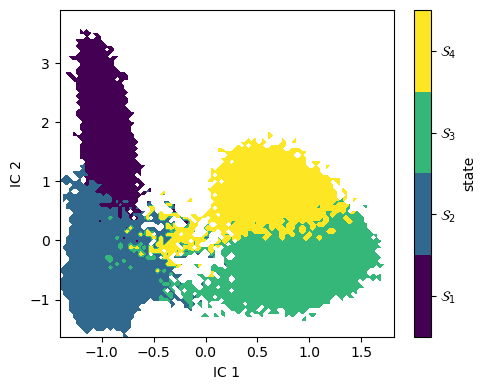

In [88]:
metastable_traj = new_assignment[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()
# fig.savefig('pcca_update.png',dpi=400)

In [89]:
# Compute MFPTs between all pairs of new PCCA+ states
mfpts = np.zeros((len(mapping), len(mapping)))
for i in range(len(mapping)):
    for j in range(len(mapping)):
        if i != j:
            mfpts[i, j] = msm.mfpt(
                msm.metastable_sets[new_assignment[i]],
                msm.metastable_sets[new_assignment[j]]
            )

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / ns:


,1,2,3,4
1,0.00,192240.32,24641.28,2170.27
2,23460517.71,0.00,24695.35,1013.82
3,27863163.00,4220590.67,0.00,1398.55
4,27865231.10,4221568.06,25521.26,0.00


#  testing two states

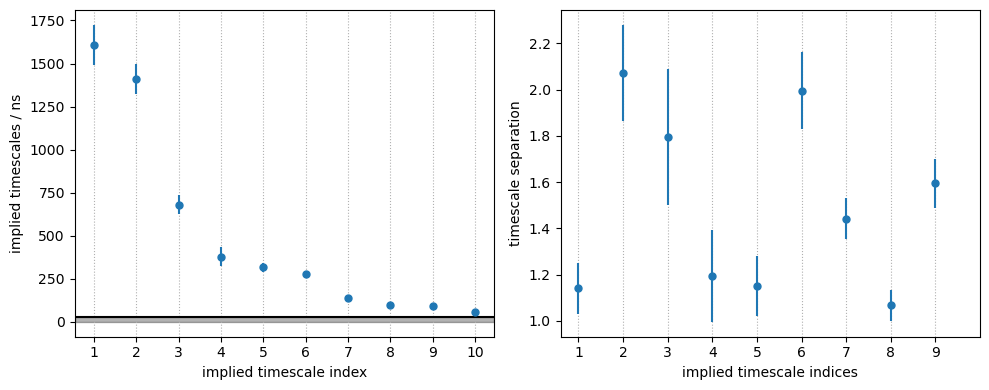

In [90]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 10

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean,
    yerr=timescales_std,
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:],
    yerr=its_separation_err(
        timescales_mean,
        timescales_std),
    fmt='.',
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')

axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
# axes[1].set_xticklabels(
#     ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
#     rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()
# plt.savefig('4state_spectral_update.png',dpi=300)

estimating BayesianMSM:   0%|                                                                                 …

/home/jaybraun/miniconda3/lib/python3.9/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')
/home/jaybraun/miniconda3/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 246 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/home/jaybraun/miniconda3/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 245 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)


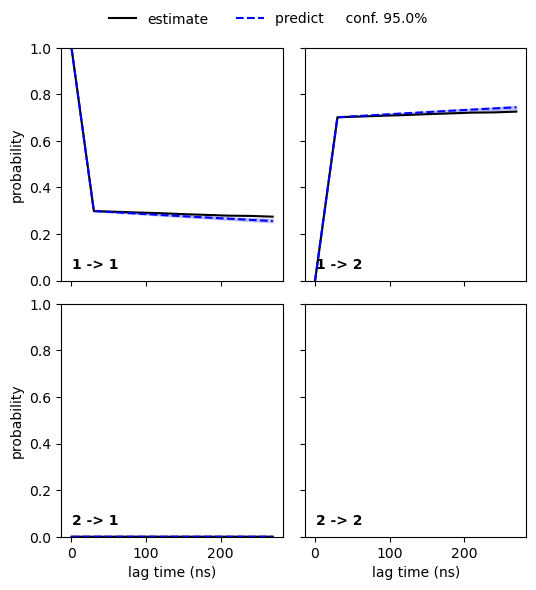

In [91]:
nstates = 2
cktest = msm.cktest(nstates)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns');
# plt.savefig('2state_cktets.png',dpi = 300)

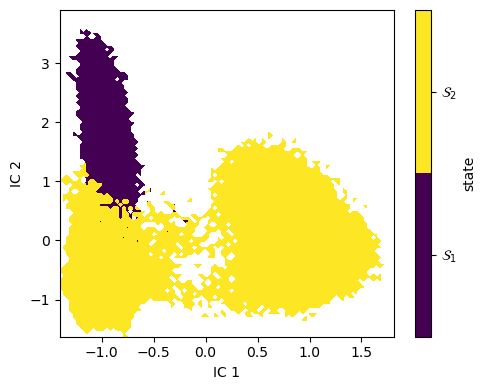

In [92]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()
# fig.savefig('2state_pcca_update.png',dpi=400)

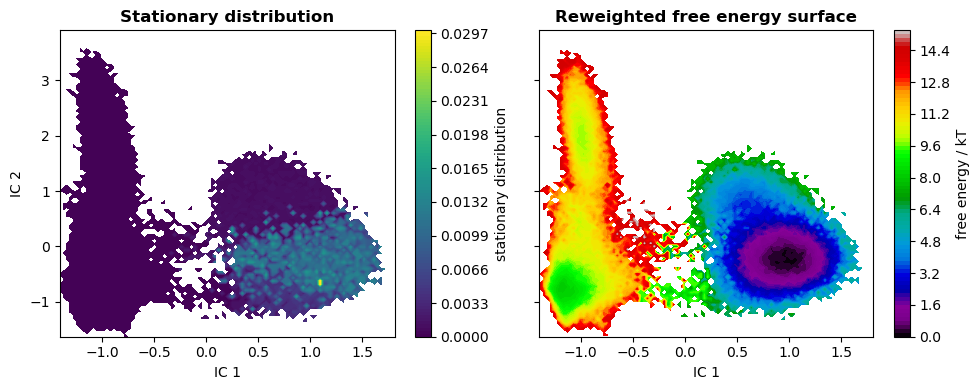

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()
# plt.savefig('macro_energy_update.png',dpi=400)

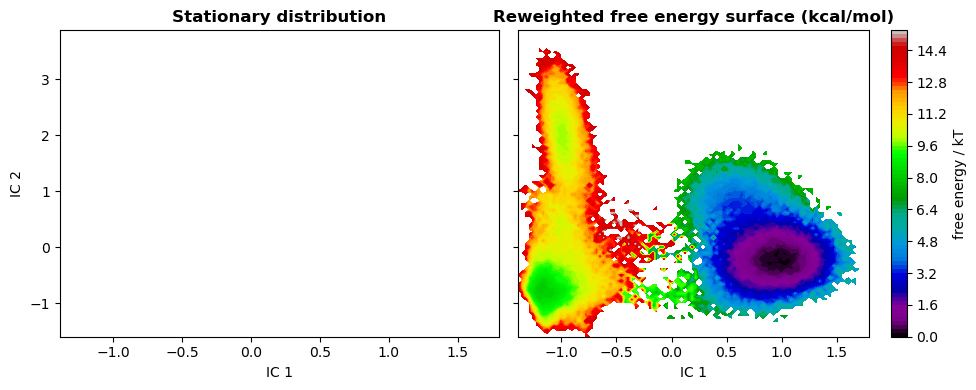

In [94]:
kB = 1.9872036e-3  # kcal/mol·K
T = 310  # You need to provide the temperature in Kelvin

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)


# Plot free energy in kcal/mol
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()) * kB * T,
    ax=axes[1],
    legacy=False)

for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface (kcal/mol)', fontweight='bold')
fig.tight_layout()


In [95]:
T = 310

/tmp/ipykernel_6588/4058992882.py:10: RuntimeWarning: divide by zero encountered in log
  fes_kBT = -np.log(hist)


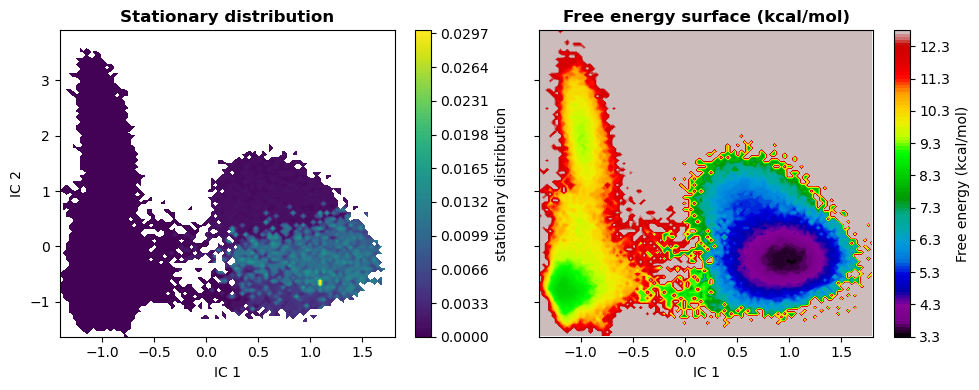

In [96]:
# Compute 2D histogram
hist, xedges, yedges = np.histogram2d(
    tica_concatenated[:, 0], tica_concatenated[:, 1], 
    bins=100, weights=np.concatenate(msm.trajectory_weights()))

# Convert histogram to probability
hist /= hist.sum()

# Convert probabilities to free energy in units of kBT
fes_kBT = -np.log(hist)

# Handle infinities
fes_kBT[np.isinf(fes_kBT)] = fes_kBT[~np.isinf(fes_kBT)].max()

# Convert the free energy to kcal/mol
fes_kcal_per_mol = fes_kBT * kB * T

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Plot stationary distribution
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')

# Plot free energy in kcal/mol
contourf = axes[1].contourf(
    (xedges[:-1] + xedges[1:]) / 2,
    (yedges[:-1] + yedges[1:]) / 2,
    fes_kcal_per_mol.T,  # transpose due to how meshgrid works
    levels=100,  # you can adjust the number of levels or provide explicit levels
    cmap='nipy_spectral'
)
cbar = fig.colorbar(contourf, ax=axes[1])
cbar.set_label('Free energy (kcal/mol)')

for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Free energy surface (kcal/mol)', fontweight='bold')
fig.tight_layout()
# plt.savefig('2state_pmf.png',dpi=400)


In [97]:
from itertools import product

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / ns:


,1,2
1,0.00,1136.75
2,27864344.75,0.00


In [135]:
A = msm.metastable_sets[0]
B = msm.metastable_sets[8]
print('MFPT 1 -> other: ({:6.1f} ± {:5.1f}) ns'.format(
    msm.sample_mean('mfpt', A, B), msm.sample_std('mfpt', A, B)))
print('MFPT other -> 1: ({:.1f} ± {:5.1f}) ns'.format(
    msm.sample_mean('mfpt', B, A), msm.sample_std('mfpt', B, A)))

MFPT 1 -> other: (2153.2 ± 100.2) ns
MFPT other -> 1: (42156118.6 ± 4775173.5) ns


In [95]:
from itertools import product

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / ns:


,1,2
1,0.000000e+00,1181.32
2,1.399996e+08,0.00


In [186]:
from itertools import product

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / ns:


,1,2,3,4
1,0.00,913540.36,21062.77,1778.42
2,37658294.31,0.00,21049.28,568.10
3,47587002.13,11119326.97,0.00,1399.30
4,47589791.53,11119930.68,21656.25,0.00


In [225]:
# Given your code:
A = msm.metastable_sets[0]
B = np.concatenate(msm.metastable_sets[1:])

mfpt_A_to_B_mean = msm.sample_mean('mfpt', B, A)
mfpt_A_to_B_std = msm.sample_std('mfpt', B, A)

# Calculate the off-rate from the MFPT
k_off_mean = 1 / mfpt_A_to_B_mean
print(k_off_mean)
k_off_std = k_off_mean * (mfpt_A_to_B_std / mfpt_A_to_B_mean)  # Error propagation for the inverse

print(f"Off-rate (from A to B): {k_off_mean:.2e} ± {k_off_std:.2e} 1/ns")


9.326674151155605e-09
Off-rate (from A to B): 9.33e-09 ± 3.77e-09 1/ns


In [99]:
metastable_traj

array([1, 1, 1, ..., 1, 1, 1])

In [137]:
import math

def calculate_k_on_off(mfpt_bound_to_unbound, mfpt_unbound_to_bound):
    k_off = 1.0 / mfpt_bound_to_unbound
    k_on = 1.0 / mfpt_unbound_to_bound
    return k_on, k_off

def calculate_deltaG(k_on, k_off, temperature):
    R = 8.314  # J/mol·K
    K = k_on / k_off
    K_reverse = k_off / k_on
    deltaG_joule = -R * temperature * math.log(K)
    deltaG_reverse_joule = -R * temperature * math.log(K_reverse)
    
    # Convert from J/mol to kcal/mol
    conversion_factor = 0.000239006
    deltaG_kcal = deltaG_joule * conversion_factor
    deltaG_reverse_kcal = deltaG_reverse_joule * conversion_factor

    print(f"k_on = {k_on:.8f} ns^-1")
    print(f"k_off = {k_off:.8f} ns^-1")
    print(f"Equilibrium constant, K = {K:.2f}")
    print(f"Reverse Equilibrium constant, K_reverse = {K_reverse:.8f}")
    print(f"Delta G (J/mol) = {deltaG_joule:.2f} J/mol")
    print(f"Delta G (kcal/mol) = {deltaG_kcal:.2f} kcal/mol")
    print(f"Delta G reverse (J/mol) = {deltaG_reverse_joule:.2f} J/mol")
    print(f"Delta G reverse (kcal/mol) = {deltaG_reverse_kcal:.2f} kcal/mol")

    return deltaG_kcal, deltaG_reverse_kcal

mfpt_bound_to_unbound = 1.399E9  # ns
mfpt_unbound_to_bound = 1181    # ns
temperature = 310               # K

k_on, k_off = calculate_k_on_off(mfpt_bound_to_unbound, mfpt_unbound_to_bound)
deltaG_forward, deltaG_reverse = calculate_deltaG(k_on, k_off, temperature)


k_on = 0.00084674 ns^-1
k_off = 0.00000000 ns^-1
Equilibrium constant, K = 1184589.33
Reverse Equilibrium constant, K_reverse = 0.00000084
Delta G (J/mol) = -36043.86 J/mol
Delta G (kcal/mol) = -8.61 kcal/mol
Delta G reverse (J/mol) = 36043.86 J/mol
Delta G reverse (kcal/mol) = 8.61 kcal/mol


In [141]:
import math

def calculate_deltaG(k_on, k_off, temperature):
    R = 8.314  # J/mol·K
    K = k_on / k_off
    deltaG_joule = -R * temperature * math.log(K)
    
    # Convert from J/mol to kcal/mol
    conversion_factor = 0.000239006
    deltaG_kcal = deltaG_joule * conversion_factor

    print(f"k_on = {k_on:.8f} ns^-1")
    print(f"k_off = {k_off:.8f} ns^-1")
    print(f"Equilibrium constant, K = {K:.2f}")
    print(f"Delta G (J/mol) = {deltaG_joule:.2f} J/mol")
    print(f"Delta G (kcal/mol) = {deltaG_kcal:.2f} kcal/mol")

    return deltaG_kcal

mfpt_bound_to_unbound = 42156118  # ns
mfpt_unbound_to_bound = 2150    # ns
temperature = 310               # K

k_on = 1.0 / mfpt_unbound_to_bound
k_off = 1.0 / mfpt_bound_to_unbound
deltaG = calculate_deltaG(k_on, k_off, temperature)


k_on = 0.00046512 ns^-1
k_off = 0.00000002 ns^-1
Equilibrium constant, K = 19607.50
Delta G (J/mol) = -25473.57 J/mol
Delta G (kcal/mol) = -6.09 kcal/mol


In [138]:
A = msm.metastable_sets[0]
B = msm.metastable_sets[7]
flux = pyemma.msm.tpt(msm, A, B)

In [139]:
print(np.isnan(top_cont[:, :2]).any())
print(np.isnan(flux.committor[cluster.dtrajs[0]]).any())


False
False


In [140]:
cg, cgflux = flux.coarse_grain(msm.metastable_sets)

In [141]:
paths, path_fluxes = cgflux.pathways(fraction=0.99)
print('percentage       \tpath')
print('-------------------------------------')
for i in range(len(paths)):
    print(np.round(path_fluxes[i] / np.sum(path_fluxes), 3),' \t', paths[i] + 1)

percentage       	path
-------------------------------------
0.647  	 [1 2 7 6 8]
0.139  	 [1 4 8]
0.129  	 [1 2 4 8]
0.021  	 [1 7 8]
0.021  	 [1 2 5 8]
0.018  	 [1 2 3 8]
0.01  	 [1 8]
0.009  	 [1 2 7 8]
0.006  	 [1 2 7 5 8]


In [241]:
A = msm.metastable_sets[0]
B = msm.metastable_sets[]
flux = pyemma.msm.tpt(msm, A, B)


In [242]:
relabeling_dict = {0: 2, 1: 3, 2: 1, 3: 5, 4: 4}


In [243]:
old_label_for_state_5 = [old for old, new in relabeling_dict.items() if new == 5][0]
old_label_for_state_4 = [old for old, new in relabeling_dict.items() if new == 4][0]


In [244]:
A = msm.metastable_sets[old_label_for_state_5]
B = msm.metastable_sets[old_label_for_state_4]


In [245]:
paths, path_fluxes = cgflux.pathways(fraction=0.99)
print('percentage       \tpath')
print('-------------------------------------')
for i in range(len(paths)):
    relabeled_path = [relabeling_dict[state] for state in paths[i]]
    print(np.round(path_fluxes[i] / np.sum(path_fluxes), 3), ' \t', relabeled_path)


percentage       	path
-------------------------------------
0.711  	 [2, 5, 4]
0.289  	 [2, 4]


In [255]:
print(relabeling_dict)
print(msm.metastable_sets)


{0: 2, 1: 3, 2: 1, 3: 5, 4: 4}
[array([  4,  20,  31,  52,  66,  83,  85,  86, 140, 158, 180, 198, 220,
       239, 247, 263, 288, 304, 306, 309, 330, 346, 362, 374, 392, 393]), array([  5,   7,  17,  19,  21,  46,  50,  70,  79,  82,  87,  95,  96,
        98, 108, 113, 114, 135, 139, 144, 150, 153, 182, 184, 191, 205,
       224, 226, 228, 252, 253, 259, 261, 266, 268, 279, 282, 301, 303,
       310, 311, 315, 318, 325, 348, 351, 357, 369, 386, 388, 390]), array([  0,   2,   6,   9,  10,  11,  13,  18,  23,  24,  25,  26,  27,
        29,  33,  37,  38,  40,  42,  44,  45,  48,  49,  51,  54,  56,
        58,  62,  65,  67,  68,  69,  73,  78,  80,  81,  89,  91, 100,
       101, 102, 106, 107, 109, 110, 116, 118, 119, 121, 122, 126, 128,
       130, 132, 134, 137, 138, 141, 143, 146, 147, 149, 151, 155, 160,
       161, 163, 164, 167, 168, 172, 173, 174, 176, 177, 181, 183, 185,
       187, 188, 189, 193, 195, 196, 197, 199, 201, 202, 203, 206, 207,
       210, 212, 213, 214, 217, 2

In [254]:

A = msm.metastable_sets[relabeling_dict[4]]  # Original state 5
B = msm.metastable_sets[relabeling_dict[3]]  # Original state 4


# Calculate the flux
flux = pyemma.msm.tpt(msm, A, B)

# Plotting the committor probabilities
fig, ax = plt.subplots(figsize=(20, 5))
pyemma.plots.plot_contour(
    *top_cont[:, :2].T,
    flux.committor[dtrajs_concatenated],
    ax=ax,
    cmap='brg',
    mask=True,
    cbar_label=r'committor A $\to$ B')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
fig.tight_layout()

# Extract the dominant pathways
paths, path_fluxes = flux.pathways(fraction=0.99)
print('percentage       \tpath')
print('-------------------------------------')
for i in range(len(paths)):
    print(np.round(path_fluxes[i] / np.sum(path_fluxes), 3), '\t', paths[i] + 1)


IndexError: list index out of range

In [ ]:
import MDAnalysis as mda

# Load the trajectory
u = mda.Universe('../adaptive_sampling_features/10.gro', '../../trajdat/rep6_tot2.xtc')

# Determine the midpoint
mid_point = len(u.trajectory) // 2

# Slice the trajectory
sliced_traj = u.trajectory[:mid_point]



In [145]:
# Define the path for saving the sliced trajectory
output_path = '../../trajdat/sliced_rep6_tot2.xtc'

# Use MDAnalysis writer to save the trajectory
with mda.Writer(output_path, n_atoms=u.atoms.n_atoms) as W:
    for ts in sliced_traj:
        W.write(u.atoms)

print(f"Sliced trajectory saved to {output_path}")


Sliced trajectory saved to ../../trajdat/sliced_rep6_tot2.xtc


In [148]:
# Replace 'rep6_tot2.xtc' with the sliced version in the list of files
sliced_traj_filename = '../../trajdat/sliced_rep6_tot2.xtc'  # Replace this with the path to your sliced trajectory
files = [f if "rep6_tot2.xtc" not in f else sliced_traj_filename for f in files]

# Print to confirm
for file in files:
    print(file)


../../trajdat/9_ext.xtc
../../trajdat/1_tot.xtc
../../trajdat/3.1_ext.xtc
../../trajdat/3_ext.xtc
../../trajdat/5_tot.xtc
../../trajdat/rep1_tot.xtc
../../trajdat/rep2_tot.xtc
../../trajdat/rep3_tot.xtc
../../trajdat/rep4.xtc
path_to_your_sliced_trajectory.xtc
../../trajdat/rep2_end.xtc


In [38]:
import sys
import os
sys.path.insert(0, '../')
import featurize.featurize_v2 as feat_
import featurize.caller_v2 as caller


path = '../../trajdat'
files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.xtc')]

for file in files:
    print(file)


../../trajdat/9_ext.xtc
../../trajdat/1_tot.xtc
../../trajdat/3.1_ext.xtc
../../trajdat/3_ext.xtc
../../trajdat/5_tot.xtc
../../trajdat/rep1_tot.xtc
../../trajdat/rep2_tot.xtc
../../trajdat/rep3_tot.xtc
../../trajdat/rep4.xtc
../../trajdat/rep2_end.xtc
../../trajdat/sliced_rep6_tot2.xtc


In [39]:
# Remove the existing entries of '../../trajdat/sliced_rep6_tot2.xtc'
files = [f for f in files if f != '../../trajdat/sliced_rep6_tot2.xtc']

# Find the index of '../../trajdat/rep2_end.xtc'
index_rep2_end = files.index('../../trajdat/rep2_end.xtc')

# Insert '../../trajdat/sliced_rep6_tot2.xtc' before that index
files.insert(index_rep2_end, '../../trajdat/sliced_rep6_tot2.xtc')

# Print to confirm
for file in files:
    print(file)


../../trajdat/9_ext.xtc
../../trajdat/1_tot.xtc
../../trajdat/3.1_ext.xtc
../../trajdat/3_ext.xtc
../../trajdat/5_tot.xtc
../../trajdat/rep1_tot.xtc
../../trajdat/rep2_tot.xtc
../../trajdat/rep3_tot.xtc
../../trajdat/rep4.xtc
../../trajdat/sliced_rep6_tot2.xtc
../../trajdat/rep2_end.xtc


7635

In [156]:
pcca_samples

array([array([[    0, 15258],
              [    0, 14535],
              [    0,  8135],
              [    8,  5847],
              [    0, 16784],
              [    0, 17250],
              [    0, 15819],
              [    0, 15307],
              [    0, 16620],
              [    0, 15133]]), array([[    8,  7021],
                                       [    4,  7160],
                                       [    4,  8716],
                                       [    3,  8963],
                                       [    3, 14621],
                                       [    5,   798],
                                       [    2,  4404],
                                       [    2,  8000],
                                       [    8,  5636],
                                       [    2,  7021]]),
       array([[    3, 12930],
              [    2,  7849],
              [    5,   667],
              [    9,  6173],
              [    2,  6472],
              [    7,  9001]

In [41]:
pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, 50)
torsions_source = pyemma.coordinates.source(files, top='../adaptive_sampling_features/10.gro')
pyemma.coordinates.save_trajs(
    torsions_source,
    pcca_samples,
    outfiles=['./ca_pair/traj6_short{}_pair.gro'.format(n + 1)
              for n in range(msm.n_metastable)])

Obtaining file info:   0%|                                                                                    …

['./ca_pair/traj6_short1_pair.gro',
 './ca_pair/traj6_short2_pair.gro',
 './ca_pair/traj6_short3_pair.gro',
 './ca_pair/traj6_short4_pair.gro',
 './ca_pair/traj6_short5_pair.gro',
 './ca_pair/traj6_short6_pair.gro',
 './ca_pair/traj6_short7_pair.gro',
 './ca_pair/traj6_short8_pair.gro']